In [2]:
print("Backprop")

Backprop


In [ ]:
import wandb
wandb.login()  # This will prompt you to enter your API key


In [2]:
import wandb

# # Initialize a wandb run
# wandb.init(project="my-awesome-project")


In [29]:
# Cell 2: Define Model Functions and NeuralNetwork Class
import numpy as np

# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x):
    return np.tanh(x)

def dtanh(x):
    return 1 - np.tanh(x)**2

def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(float)

def identity(x):
    return x

def didentity(x):
    return np.ones_like(x)

def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

# Loss functions
def cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    return loss

def mse_loss(y_pred, y_true):
    loss = np.mean(0.5 * np.square(y_true - y_pred))
    return loss

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation, weight_init, loss_func):
        # Select activation function
        self.activation_str = activation.lower()
        if self.activation_str == 'sigmoid':
            self.activation = sigmoid
            self.activation_deriv = dsigmoid
            
        elif self.activation_str == 'tanh':
            self.activation = tanh
            self.activation_deriv = dtanh
            
        elif self.activation_str == 'relu':
            self.activation = relu
            self.activation_deriv = drelu
            
        elif self.activation_str == 'identity':
            self.activation = identity
            self.activation_deriv = didentity
            
        else:
            raise ValueError("Unknown activation function.")
        
        # Select loss function
        self.loss_func_name = loss_func.lower()
        if self.loss_func_name == 'cross_entropy':
            self.loss_func = cross_entropy_loss
            
        elif self.loss_func_name == 'mean_squared_error':
            self.loss_func = mse_loss
        else:
            raise ValueError("Unknown loss function.")
        
        
        # Define layer sizes: input -> hidden layers -> output
        self.layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.num_layers = len(self.layer_sizes) - 1
        
        # Initialize weights and biases
        self.params = {}
        for i in range(1, len(self.layer_sizes)):
            if weight_init.lower() == 'xavier':
                limit = np.sqrt(6 / (self.layer_sizes[i-1] + self.layer_sizes[i]))
                self.params['W' + str(i)] = np.random.uniform(-limit, limit, (self.layer_sizes[i-1], self.layer_sizes[i]))
            else:  # 'random'
                self.params['W' + str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * 0.01
            self.params['b' + str(i)] = np.zeros((1, self.layer_sizes[i]))
    
    def forward(self, X):
        cache = {}
        A = X
        cache['A0'] = A
        # Hidden layers
        for i in range(1, self.num_layers):
            Z = np.dot(A, self.params['W' + str(i)]) + self.params['b' + str(i)]
            cache['Z' + str(i)] = Z
            A = self.activation(Z)
            cache['A' + str(i)] = A
        # Output layer with softmax
        Z = np.dot(A, self.params['W' + str(self.num_layers)]) + self.params['b' + str(self.num_layers)]
        cache['Z' + str(self.num_layers)] = Z
        A = softmax(Z)
        cache['A' + str(self.num_layers)] = A
        return A, cache
    
    def compute_loss(self, y_pred, y_true):
        return self.loss_func(y_pred, y_true)
    
    def backward(self, X, y_true, cache):
        grads = {}
        m = X.shape[0]
        A_final = cache['A' + str(self.num_layers)]
        
        if self.loss_func_name == 'cross_entropy':
            dZ = (A_final - y_true) / m
        else:
            dZ = (A_final - y_true) / m
        
        # Output layer gradients
        A_prev = cache['A' + str(self.num_layers - 1)]
        grads['dW' + str(self.num_layers)] = np.dot(A_prev.T, dZ)
        grads['db' + str(self.num_layers)] = np.sum(dZ, axis=0, keepdims=True)
        
        # Backpropagation through hidden layers
        for i in range(self.num_layers - 1, 0, -1):
            dA = np.dot(dZ, self.params['W' + str(i + 1)].T)
            Z = cache['Z' + str(i)]
            dZ = dA * self.activation_deriv(Z)
            A_prev = cache['A' + str(i - 1)]
            grads['dW' + str(i)] = np.dot(A_prev.T, dZ)
            grads['db' + str(i)] = np.sum(dZ, axis=0, keepdims=True)
        
        return grads


In [30]:
# Cell 3: Define the Optimizer Class
class Optimizer:
    def __init__(self, params, optimizer_name, learning_rate, momentum=0.5,
                 beta=0.5, beta1=0.5, beta2=0.5, epsilon=1e-6, weight_decay=0.0):
        
        self.optimizer_name = optimizer_name.lower()
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.t = 0  # timestep for Adam/Nadam
        
        # Initialize optimizer states
        self.v = {}  # For momentum or Adam's first moment
        self.s = {}  # For RMSProp or Adam's second moment
        for key, val in params.items():
            self.v[key] = np.zeros_like(val)
            self.s[key] = np.zeros_like(val)
        self.param_keys = list(params.keys())
    
    def update(self, params, grads):
        self.t += 1
        
        for key in self.param_keys:
            grad = grads['d' + key]
            
            # Applying weight decay to weights only
            if key.startswith('W'):
                grad += self.weight_decay * params[key]
            
            if self.optimizer_name == 'sgd':
                params[key] -= self.learning_rate * grad
                
            elif self.optimizer_name == 'momentum':
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad
                params[key] += self.v[key]
                
            
            elif self.optimizer_name in ['nag', 'nesterov']:
                v_prev = self.v[key].copy()
                self.v[key] = self.momentum * self.v[key] - self.learning_rate * grad
                params[key] += -self.momentum * v_prev + (1 + self.momentum) * self.v[key]
                
            
            elif self.optimizer_name == 'rmsprop':
                self.s[key] = self.beta * self.s[key] + (1 - self.beta) * (grad ** 2)
                params[key] -= self.learning_rate * grad / (np.sqrt(self.s[key]) + self.epsilon)
                
            
            elif self.optimizer_name == 'adam':
                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grad
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (grad ** 2)
                v_corr = self.v[key] / (1 - self.beta1 ** self.t)
                s_corr = self.s[key] / (1 - self.beta2 ** self.t)
                params[key] -= self.learning_rate * v_corr / (np.sqrt(s_corr) + self.epsilon)
                
            
            elif self.optimizer_name == 'nadam':
                self.v[key] = self.beta1 * self.v[key] + (1 - self.beta1) * grad
                self.s[key] = self.beta2 * self.s[key] + (1 - self.beta2) * (grad ** 2)
                v_corr = self.v[key] / (1 - self.beta1 ** self.t)
                s_corr = self.s[key] / (1 - self.beta2 ** self.t)
                params[key] -= self.learning_rate * (self.beta1 * v_corr + (1 - self.beta1) * grad) / (np.sqrt(s_corr) + self.epsilon)
                
            else:
                raise ValueError("Unknown optimizer: " + self.optimizer_name)


In [31]:
# Cell 4: Utility Functions
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

def load_data(dataset="fashion_mnist"):
    
    if dataset == "fashion_mnist":
        (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
        
    elif dataset == "mnist":
        from keras.datasets import mnist
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        
    else:
        raise ValueError("Unknown dataset.")
    
    # Normalize and reshape data
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    
    num_classes = 10
    
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Split 10% of training data for validation
    split_index = int(0.9 * X_train.shape[0])
    X_val = X_train[split_index:]
    y_val = y_train[split_index:]
    X_train = X_train[:split_index]
    y_train = y_train[:split_index]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def train_model(network, optimizer, X_train, y_train, X_val, y_val, epochs, batch_size):
    num_samples = X_train.shape[0]
    steps_per_epoch = num_samples // batch_size
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        epoch_loss = 0
        epoch_acc = 0
        
        for step in range(steps_per_epoch):
            start = step * batch_size
            end = start + batch_size
            
            X_batch = X_train[start:end]
            y_batch = y_train[start:end]
            
            # Forward pass
            y_pred, cache = network.forward(X_batch)
            loss = network.compute_loss(y_pred, y_batch)
            epoch_loss += loss
            
            # Accuracy calculation
            predictions = np.argmax(y_pred, axis=1)
            true_labels = np.argmax(y_batch, axis=1)
            acc = np.mean(predictions == true_labels)
            epoch_acc += acc
            
            # Backward pass and update
            grads = network.backward(X_batch, y_batch, cache)
            optimizer.update(network.params, grads)
        
        epoch_loss /= steps_per_epoch
        epoch_acc /= steps_per_epoch
        
        # Evaluate on validation data
        y_val_pred, _ = network.forward(X_val)
        val_loss = network.compute_loss(y_val_pred, y_val)
        predictions_val = np.argmax(y_val_pred, axis=1)
        true_labels_val = np.argmax(y_val, axis=1)
        val_acc = np.mean(predictions_val == true_labels_val)
        
        print(f"Epoch {epoch+1}/{epochs}: Loss={epoch_loss:.4f}, Acc={epoch_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
    
    return network

def evaluate_model(network, X_test, y_test):
    y_pred, _ = network.forward(X_test)
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_test, axis=1)
    test_acc = np.mean(predictions == true_labels)
    print(f"Test Accuracy: {test_acc:.4f}")
    return predictions, true_labels, test_acc

def plot_conf_matrix(true_labels, predictions, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


4431872/4422102 [==============================] - 1s 0us/step
Epoch 1/5: Loss=0.5225, Acc=0.8129, Val Loss=0.4337, Val Acc=0.8410
Epoch 2/5: Loss=0.3862, Acc=0.8597, Val Loss=0.3725, Val Acc=0.8660
Epoch 3/5: Loss=0.3447, Acc=0.8743, Val Loss=0.3380, Val Acc=0.8752
Epoch 4/5: Loss=0.3256, Acc=0.8800, Val Loss=0.3471, Val Acc=0.8682
Epoch 5/5: Loss=0.3100, Acc=0.8853, Val Loss=0.3504, Val Acc=0.8748
Test Accuracy: 0.8663


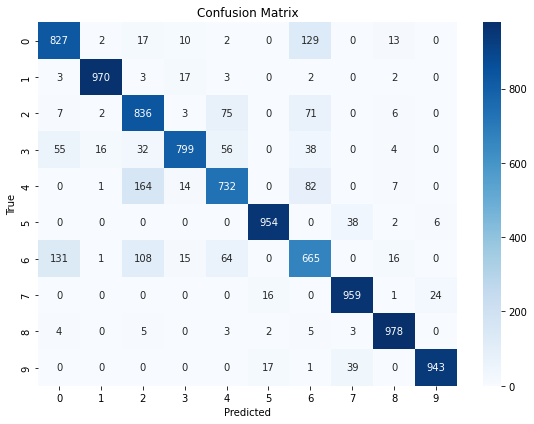

wandb: ERROR Control-C detected -- Run data was not synced


In [13]:
# Cell 5: Main Training Loop & Wandb Initialization
import wandb

# Initialize a new Wandb run
wandb.init(project="DL_Assignment_01")
config = wandb.config
config.learning_rate = 0.001
config.batch_size = 32
config.epochs = 5
config.num_layers = 2      # Example: 2 hidden layers
config.hidden_size = 64    # Example: 64 neurons per hidden layer
config.activation = "relu"
config.weight_init = "xavier"
config.loss = "cross_entropy"
config.optimizer = "adam"  # Options: sgd, momentum, nag, rmsprop, adam, nadam
config.momentum = 0.9
config.beta = 0.9
config.beta1 = 0.9
config.beta2 = 0.999
config.epsilon = 1e-8
config.weight_decay = 0.0001

# Load and preprocess data
X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
input_size = X_train.shape[1]
output_size = 10  # 10 classes
hidden_sizes = [config.hidden_size] * config.num_layers

# Initialize the Neural Network and Optimizer
network = NeuralNetwork(input_size, hidden_sizes, output_size, config.activation, config.weight_init, config.loss)
optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                      momentum=config.momentum, beta=config.beta,
                      beta1=config.beta1, beta2=config.beta2,
                      epsilon=config.epsilon, weight_decay=config.weight_decay)

# Train the model
network = train_model(network, optimizer, X_train, y_train, X_val, y_val, config.epochs, config.batch_size)

# Evaluate the model on the test set
predictions, true_labels, test_acc = evaluate_model(network, X_test, y_test)

# Plot the confusion matrix
classes = [str(i) for i in range(10)]
plot_conf_matrix(true_labels, predictions, classes)

# Finish the Wandb run
wandb.finish()


In [6]:
import numpy as np
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess one sample image: flatten and scale to [0,1]
sample_image = X_train[0].reshape(1, -1) / 255.0

# For testing, initialize the network with example parameters
# (input_size, one hidden layer of size 64, output_size=10)
input_size = sample_image.shape[1]  # 28*28 = 784
hidden_sizes = [64]
output_size = 10

# Create a network instance using your NeuralNetwork class.
# Make sure your class uses softmax on the output layer.
model = NeuralNetwork(input_size, hidden_sizes, output_size, activation="relu", weight_init="xavier", loss_func="cross_entropy")

# Run the forward pass on the sample image
output_distribution, _ = model.forward(sample_image)

# Print the output distribution and verify it sums to 1
print("Output Distribution:", output_distribution)
print("Sum of probabilities:", np.sum(output_distribution))


Output Distribution: [[0.05956064 0.10098628 0.10666361 0.08184834 0.20911503 0.07191097
  0.06679764 0.07492031 0.14337602 0.08482115]]
Sum of probabilities: 0.9999999999999998


In [ ]:
### Feed forward neural network...

import numpy as np
from keras.datasets import fashion_mnist

# writing the forward propagation function below

def forward_propagation(X, W1, b1, W2, b2):
    # First layer
    Z1 = np.dot(X, W1) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    # Second layer
    Z2 = np.dot(A1, W2) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=1, keepdims=True)  # Softmax activation
    return Z1, A1, Z2, A2

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess one sample image: flatten and scale to [0,1]
sample_image = X_train[0].reshape(1, -1) / 255.0

# For testing, initialize the network with example parameters
# (input_size, one hidden layer of size 64, output_size=10)
input_size = sample_image.shape[1]  # 28*28 = 784
hidden_size = 64
output_size = 10
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

# Run the forward pass on the sample image
Z1, A1, Z2, A2 = forward_propagation(sample_image, W1, b1, W2, b2)

# Print the output distribution and verify it sums to 1
print("Output Distribution:", A2)
print("Sum of probabilities:", np.sum(A2))



Output Distribution: [[0.09989649 0.10005848 0.09988035 0.10028819 0.10069198 0.10001923
  0.09957533 0.09984086 0.09980419 0.0999449 ]]
Sum of probabilities: 1.0


In [17]:
### Backpropagation...
import numpy as np
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Preprocess one sample image: flatten and scale to [0,1]
sample_image = X_train[0].reshape(1, -1) / 255.0
sample_label = np.eye(10)[y_train[0]].reshape(1, -1)

# For testing, initialize the network with example parameters
# (input_size, one hidden layer of size 64, output_size=10)
input_size = sample_image.shape[1]  # 28*28 = 784
hidden_size = 64
output_size = 10
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

W1 = np.random.randn(input_size, hidden_size) * np.sqrt(1/input_size)
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1/hidden_size)
b2 = np.zeros((1, output_size))



# Define the ReLU activation and its derivative
def relu(x):
    return np.maximum(0, x)

def drelu(x):
    return (x > 0).astype(float)

# Define the softmax cross-entropy loss and its derivative
def softmax(x):
    exp_shifted = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.sum(y_true * np.log(y_pred)) / y_pred.shape[0]
    return loss
    
def dsoftmax_cross_entropy(y_pred, y_true):
    return y_pred - y_true
    
# Define the forward propagation function
def forward_propagation(X, W1, b1, W2, b2):
    # First layer
    Z1 = np.dot(X, W1) + b1
    A1 = relu(Z1)
    # Second layer
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2
    

# Define the backward propagation function
def backward_propagation(X, Y, Z1, A1, Z2, A2, W1, W2, b1, b2):
    m = X.shape[0]
    dZ2 = dsoftmax_cross_entropy(A2, Y) / m
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * drelu(Z1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)
    return dW1, db1, dW2, db2
    
# Run the forward pass on the sample image
Z1, A1, Z2, A2 = forward_propagation(sample_image, W1, b1, W2, b2)

print("Output Distribution:", A2)
print("Sum of probabilities:", np.sum(A2))

print(sample_label)
# Compute the loss
loss = cross_entropy_loss(A2, sample_label)
print("Loss:", loss)

# Run the backward pass to get the gradients
dW1, db1, dW2, db2 = backward_propagation(sample_image, sample_label, Z1, A1, Z2, A2, W1, W2, b1, b2)

# Print the gradients
print("dW1:", dW1)
print("db1:", db1)
print("dW2:", dW2)
print("db2:", db2)



Output Distribution: [[0.09431552 0.12771193 0.08795426 0.07637771 0.14160953 0.10646259
  0.0861068  0.0938164  0.11274598 0.07289927]]
Sum of probabilities: 1.0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss: 2.6186766073387537
dW1: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
db1: [[ 0.          0.          0.         -0.15783471 -0.07748646  0.
   0.          0.11317802  0.1769541   0.          0.          0.
  -0.01763823  0.          0.          0.          0.04075311  0.
   0.          0.          0.         -0.05723161  0.16450165  0.
   0.          0.24007364 -0.09735636  0.          0.          0.
   0.          0.03370892  0.05308439  0.         -0.11472456 -0.1579607
   0.10065864  0.          0.18341751  0.13736297  0.          0.
   0.          0.         -0.09121942  0.          0.          0.15275462
   0.          0.          0.         -0.02696876  0.08762267  0.
   

In [26]:
import wandb

sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization; change to "random" if preferred.
    'name': 'sweep-cross-entropy-different-optimizers',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimiser': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: yk6n6xt2
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/yk6n6xt2
Sweep ID: yk6n6xt2


In [32]:
def sweep_train():
    # Initialize a new run; configuration values are pulled from the sweep config.
    run = wandb.init()
    config = wandb.config

    # Set the run name based on the sweep configuration.
    # Note: Keys must match those in the sweep configuration.
    run_name = f"{config.optimiser}_{config.activation}_{config.hidden_layers}_{config.hidden_layer_size}_{config.batch_size}"
    wandb.run.name = run_name
    print("Run Name:", run_name)
    
    # --- Data Loading & Preprocessing ---
    from keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    # Normalize and reshape images
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Split training data: 90% train, 10% validation
    split_index = int(0.9 * X_train.shape[0])
    X_val = X_train[split_index:]
    y_val = y_train[split_index:]
    X_train = X_train[:split_index]
    y_train = y_train[:split_index]
    
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = num_classes
    
    # Create a list of hidden layer sizes
    hidden_sizes = [config.hidden_layer_size] * config.hidden_layers

    # --- Model & Optimizer Initialization ---
    # Assuming NeuralNetwork and Optimizer classes have been defined in previous cells.
    model = NeuralNetwork(input_size, hidden_sizes, output_size, 
                          activation=config.activation, 
                          weight_init=config.weight_init, 
                          loss_func="cross_entropy")
    
    optimizer = Optimizer(model.params, config.optimiser, config.learning_rate,
                          momentum=0.9, beta=0.9, beta1=0.9, beta2=0.999,
                          epsilon=1e-8, weight_decay=config.weight_decay)
    
    # --- Training ---
    # Assuming train_model is a function that trains the model and logs per-epoch metrics.
    model = train_model(model, optimizer, X_train, y_train, X_val, y_val, 
                        epochs=config.epochs, batch_size=config.batch_size)
    
    # --- Evaluation on Validation Set ---
    y_val_pred, _ = model.forward(X_val)
    val_loss = model.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    run.finish()


In [33]:
wandb.agent(sweep_id, function=sweep_train, count=100)
print("Sweep completed!")

wandb: Agent Starting Run: 0f28t4xn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_32_64
Epoch 1/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0998, Val Loss=2.3026, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3026, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0998, Val Loss=2.3026, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3027, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3027, Val Acc=0.0925


accuracy,▁▄▆▄██▄▃██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▄▃▃▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▅▆▇▇█
accuracy,0.10089
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.3027


wandb: Agent Starting Run: r7xyz75o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_32
Epoch 1/10: Loss=2.3026, Acc=0.0985, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0998, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0990, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.0985, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▂▅▆█▅█▂▆▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▃▃▂▁▁▂▃
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▄▆▆▇▇▇██
accuracy,0.09853
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30277


wandb: Agent Starting Run: wqfbt884 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_16
Epoch 1/5: Loss=2.3026, Acc=0.0957, Val Loss=2.3027, Val Acc=0.0925
Epoch 2/5: Loss=2.3026, Acc=0.0981, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/5: Loss=2.3026, Acc=0.0984, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/5: Loss=2.3026, Acc=0.0995, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/5: Loss=2.3026, Acc=0.0999, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▄▆▆█
accuracy,0.09994
epoch,5
final_val_accuracy,0.0925
final_val_loss,2.30279


wandb: Agent Starting Run: j9pvx7cc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_3_32_16
Epoch 1/5: Loss=0.8293, Acc=0.7412, Val Loss=0.5431, Val Acc=0.8148
Epoch 2/5: Loss=0.4891, Acc=0.8312, Val Loss=0.4546, Val Acc=0.8370
Epoch 3/5: Loss=0.4331, Acc=0.8481, Val Loss=0.4345, Val Acc=0.8410
Epoch 4/5: Loss=0.4068, Acc=0.8557, Val Loss=0.4081, Val Acc=0.8538
Epoch 5/5: Loss=0.3889, Acc=0.8629, Val Loss=0.3959, Val Acc=0.8553


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
accuracy,0.86294
epoch,5
final_val_accuracy,0.85533
final_val_loss,0.39592


wandb: Agent Starting Run: hpp71gb2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_tanh_4_64_32
Epoch 1/10: Loss=1.5581, Acc=0.5328, Val Loss=1.1469, Val Acc=0.6893
Epoch 2/10: Loss=0.9804, Acc=0.7131, Val Loss=0.8453, Val Acc=0.7420
Epoch 3/10: Loss=0.7813, Acc=0.7509, Val Loss=0.7171, Val Acc=0.7613
Epoch 4/10: Loss=0.6863, Acc=0.7691, Val Loss=0.6497, Val Acc=0.7815
Epoch 5/10: Loss=0.6302, Acc=0.7823, Val Loss=0.6040, Val Acc=0.7928
Epoch 6/10: Loss=0.5907, Acc=0.7940, Val Loss=0.5718, Val Acc=0.7978
Epoch 7/10: Loss=0.5608, Acc=0.8042, Val Loss=0.5478, Val Acc=0.8065
Epoch 8/10: Loss=0.5375, Acc=0.8118, Val Loss=0.5271, Val Acc=0.8123
Epoch 9/10: Loss=0.5192, Acc=0.8187, Val Loss=0.5129, Val Acc=0.8185
Epoch 10/10: Loss=0.5037, Acc=0.8244, Val Loss=0.4989, Val Acc=0.8203


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▃▃▂▂▂▁▁▁
accuracy,0.82443
epoch,10
final_val_accuracy,0.82033
final_val_loss,0.49886


wandb: Agent Starting Run: ylpt1j7o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_16
Epoch 1/5: Loss=0.8307, Acc=0.7361, Val Loss=0.5303, Val Acc=0.8220
Epoch 2/5: Loss=0.4798, Acc=0.8347, Val Loss=0.4442, Val Acc=0.8423
Epoch 3/5: Loss=0.4207, Acc=0.8524, Val Loss=0.4190, Val Acc=0.8472
Epoch 4/5: Loss=0.3926, Acc=0.8613, Val Loss=0.3918, Val Acc=0.8542
Epoch 5/5: Loss=0.3726, Acc=0.8681, Val Loss=0.3777, Val Acc=0.8637


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▆█
val_loss,█▄▃▂▁
accuracy,0.86811
epoch,5
final_val_accuracy,0.86367
final_val_loss,0.37768


wandb: Agent Starting Run: tfox4t9f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_128_32
Epoch 1/10: Loss=1.3980, Acc=0.5805, Val Loss=0.9724, Val Acc=0.6955
Epoch 2/10: Loss=0.8479, Acc=0.7213, Val Loss=0.7504, Val Acc=0.7468
Epoch 3/10: Loss=0.7055, Acc=0.7577, Val Loss=0.6588, Val Acc=0.7723
Epoch 4/10: Loss=0.6334, Acc=0.7807, Val Loss=0.6037, Val Acc=0.7888
Epoch 5/10: Loss=0.5867, Acc=0.7967, Val Loss=0.5656, Val Acc=0.8017
Epoch 6/10: Loss=0.5530, Acc=0.8071, Val Loss=0.5369, Val Acc=0.8137
Epoch 7/10: Loss=0.5277, Acc=0.8150, Val Loss=0.5162, Val Acc=0.8220
Epoch 8/10: Loss=0.5084, Acc=0.8210, Val Loss=0.5002, Val Acc=0.8255
Epoch 9/10: Loss=0.4931, Acc=0.8262, Val Loss=0.4865, Val Acc=0.8283
Epoch 10/10: Loss=0.4806, Acc=0.8298, Val Loss=0.4747, Val Acc=0.8318


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.82982
epoch,10
final_val_accuracy,0.83183
final_val_loss,0.47472


wandb: Agent Starting Run: sg8osmix with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_4_128_16
Epoch 1/5: Loss=1.5870, Acc=0.3822, Val Loss=1.1097, Val Acc=0.5900
Epoch 2/5: Loss=0.9041, Acc=0.6697, Val Loss=0.7589, Val Acc=0.7455
Epoch 3/5: Loss=0.7038, Acc=0.7500, Val Loss=0.6636, Val Acc=0.7647
Epoch 4/5: Loss=0.6263, Acc=0.7763, Val Loss=0.6019, Val Acc=0.7867
Epoch 5/5: Loss=0.5847, Acc=0.7897, Val Loss=0.5682, Val Acc=0.7922


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▂▁▁
accuracy,0.78974
epoch,5
final_val_accuracy,0.79217
final_val_loss,0.56823


wandb: Agent Starting Run: 2vhigmjp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_sigmoid_5_64_16
Epoch 1/10: Loss=2.3135, Acc=0.1002, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/10: Loss=2.3030, Acc=0.0981, Val Loss=2.3028, Val Acc=0.1037
Epoch 3/10: Loss=2.3030, Acc=0.0974, Val Loss=2.3029, Val Acc=0.0942
Epoch 4/10: Loss=2.3030, Acc=0.0988, Val Loss=2.3029, Val Acc=0.0985
Epoch 5/10: Loss=2.3029, Acc=0.0983, Val Loss=2.3032, Val Acc=0.1003
Epoch 6/10: Loss=2.3029, Acc=0.0997, Val Loss=2.3029, Val Acc=0.0925
Epoch 7/10: Loss=2.3029, Acc=0.1004, Val Loss=2.3030, Val Acc=0.0942
Epoch 8/10: Loss=2.3028, Acc=0.0980, Val Loss=2.3027, Val Acc=0.1008
Epoch 9/10: Loss=2.3028, Acc=0.0985, Val Loss=2.3023, Val Acc=0.1055
Epoch 10/10: Loss=2.3028, Acc=0.1004, Val Loss=2.3030, Val Acc=0.0925


accuracy,█▃▁▄▃▆█▂▃█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▇▂▄▅▁▂▅█▁
val_loss,▆▅▆▆█▆▇▅▁▇
accuracy,0.10043
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30298


wandb: Agent Starting Run: n0vl99hv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_16
Epoch 1/5: Loss=0.6307, Acc=0.7898, Val Loss=0.4390, Val Acc=0.8427
Epoch 2/5: Loss=0.4235, Acc=0.8487, Val Loss=0.3942, Val Acc=0.8558
Epoch 3/5: Loss=0.3881, Acc=0.8606, Val Loss=0.3812, Val Acc=0.8577
Epoch 4/5: Loss=0.3662, Acc=0.8688, Val Loss=0.3604, Val Acc=0.8682
Epoch 5/5: Loss=0.3513, Acc=0.8729, Val Loss=0.3506, Val Acc=0.8710


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▂▁
accuracy,0.87285
epoch,5
final_val_accuracy,0.871
final_val_loss,0.35062


wandb: Agent Starting Run: ma3j831x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_64_32
Epoch 1/5: Loss=0.7433, Acc=0.7605, Val Loss=0.4874, Val Acc=0.8298
Epoch 2/5: Loss=0.4541, Acc=0.8410, Val Loss=0.4286, Val Acc=0.8440
Epoch 3/5: Loss=0.4097, Acc=0.8553, Val Loss=0.3973, Val Acc=0.8520
Epoch 4/5: Loss=0.3845, Acc=0.8627, Val Loss=0.3916, Val Acc=0.8598
Epoch 5/5: Loss=0.3675, Acc=0.8688, Val Loss=0.3712, Val Acc=0.8650


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▂▁
accuracy,0.86879
epoch,5
final_val_accuracy,0.865
final_val_loss,0.37118


wandb: Agent Starting Run: bs7rww7u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_3_128_32
Epoch 1/10: Loss=0.6218, Acc=0.7912, Val Loss=0.4402, Val Acc=0.8455
Epoch 2/10: Loss=0.4219, Acc=0.8500, Val Loss=0.3967, Val Acc=0.8547
Epoch 3/10: Loss=0.3875, Acc=0.8616, Val Loss=0.3755, Val Acc=0.8627
Epoch 4/10: Loss=0.3660, Acc=0.8694, Val Loss=0.3656, Val Acc=0.8677
Epoch 5/10: Loss=0.3523, Acc=0.8731, Val Loss=0.3748, Val Acc=0.8677
Epoch 6/10: Loss=0.3405, Acc=0.8777, Val Loss=0.3530, Val Acc=0.8682
Epoch 7/10: Loss=0.3288, Acc=0.8818, Val Loss=0.3459, Val Acc=0.8753
Epoch 8/10: Loss=0.3212, Acc=0.8836, Val Loss=0.3642, Val Acc=0.8650
Epoch 9/10: Loss=0.3139, Acc=0.8870, Val Loss=0.3347, Val Acc=0.8787
Epoch 10/10: Loss=0.3072, Acc=0.8892, Val Loss=0.3372, Val Acc=0.8718


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▆▆▇▅█▇
val_loss,█▅▄▃▄▂▂▃▁▁
accuracy,0.88917
epoch,10
final_val_accuracy,0.87183
final_val_loss,0.33721


wandb: Agent Starting Run: m2w7nj3i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_3_128_32
Epoch 1/10: Loss=1.3647, Acc=0.5872, Val Loss=0.9521, Val Acc=0.7108
Epoch 2/10: Loss=0.8450, Acc=0.7279, Val Loss=0.7491, Val Acc=0.7503
Epoch 3/10: Loss=0.7112, Acc=0.7636, Val Loss=0.6616, Val Acc=0.7720
Epoch 4/10: Loss=0.6415, Acc=0.7829, Val Loss=0.6092, Val Acc=0.7877
Epoch 5/10: Loss=0.5967, Acc=0.7967, Val Loss=0.5736, Val Acc=0.7973
Epoch 6/10: Loss=0.5646, Acc=0.8063, Val Loss=0.5470, Val Acc=0.8077
Epoch 7/10: Loss=0.5404, Acc=0.8129, Val Loss=0.5306, Val Acc=0.8110
Epoch 8/10: Loss=0.5218, Acc=0.8190, Val Loss=0.5112, Val Acc=0.8172
Epoch 9/10: Loss=0.5065, Acc=0.8228, Val Loss=0.4995, Val Acc=0.8207
Epoch 10/10: Loss=0.4941, Acc=0.8274, Val Loss=0.4887, Val Acc=0.8228


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
accuracy,0.82745
epoch,10
final_val_accuracy,0.82283
final_val_loss,0.48868


wandb: Agent Starting Run: gdchwt1c with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_32
Epoch 1/5: Loss=0.6314, Acc=0.7873, Val Loss=0.4579, Val Acc=0.8332
Epoch 2/5: Loss=0.4237, Acc=0.8501, Val Loss=0.4025, Val Acc=0.8542
Epoch 3/5: Loss=0.3893, Acc=0.8614, Val Loss=0.3831, Val Acc=0.8573
Epoch 4/5: Loss=0.3685, Acc=0.8678, Val Loss=0.3743, Val Acc=0.8643
Epoch 5/5: Loss=0.3545, Acc=0.8724, Val Loss=0.3563, Val Acc=0.8688


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.87239
epoch,5
final_val_accuracy,0.86883
final_val_loss,0.3563


wandb: Agent Starting Run: 2csf77ni with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_16
Epoch 1/5: Loss=0.6212, Acc=0.7886, Val Loss=0.4555, Val Acc=0.8368
Epoch 2/5: Loss=0.4311, Acc=0.8485, Val Loss=0.4090, Val Acc=0.8573
Epoch 3/5: Loss=0.3909, Acc=0.8598, Val Loss=0.3768, Val Acc=0.8670
Epoch 4/5: Loss=0.3634, Acc=0.8691, Val Loss=0.3638, Val Acc=0.8700
Epoch 5/5: Loss=0.3467, Acc=0.8754, Val Loss=0.3615, Val Acc=0.8698


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▅▂▁▁
accuracy,0.87543
epoch,5
final_val_accuracy,0.86983
final_val_loss,0.36145


wandb: Agent Starting Run: urr9mw29 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_16
Epoch 1/5: Loss=0.6916, Acc=0.7691, Val Loss=0.4835, Val Acc=0.8330
Epoch 2/5: Loss=0.4422, Acc=0.8458, Val Loss=0.4334, Val Acc=0.8468
Epoch 3/5: Loss=0.4009, Acc=0.8581, Val Loss=0.4111, Val Acc=0.8487
Epoch 4/5: Loss=0.3763, Acc=0.8662, Val Loss=0.3971, Val Acc=0.8597
Epoch 5/5: Loss=0.3586, Acc=0.8714, Val Loss=0.3847, Val Acc=0.8572


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▅█▇
val_loss,█▄▃▂▁
accuracy,0.87135
epoch,5
final_val_accuracy,0.85717
final_val_loss,0.3847


wandb: Agent Starting Run: 07uo8ktp with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_16
Epoch 1/5: Loss=0.6064, Acc=0.7922, Val Loss=0.4455, Val Acc=0.8425
Epoch 2/5: Loss=0.4141, Acc=0.8537, Val Loss=0.4011, Val Acc=0.8545
Epoch 3/5: Loss=0.3722, Acc=0.8665, Val Loss=0.3889, Val Acc=0.8632
Epoch 4/5: Loss=0.3460, Acc=0.8761, Val Loss=0.3531, Val Acc=0.8690
Epoch 5/5: Loss=0.3251, Acc=0.8823, Val Loss=0.3391, Val Acc=0.8765


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▃▅▆█
val_loss,█▅▄▂▁
accuracy,0.88228
epoch,5
final_val_accuracy,0.8765
final_val_loss,0.33909


wandb: Agent Starting Run: u4cv1q1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_32
Epoch 1/5: Loss=0.5109, Acc=0.8147, Val Loss=0.4020, Val Acc=0.8530
Epoch 2/5: Loss=0.3877, Acc=0.8579, Val Loss=0.3848, Val Acc=0.8617
Epoch 3/5: Loss=0.3600, Acc=0.8673, Val Loss=0.4008, Val Acc=0.8567
Epoch 4/5: Loss=0.3419, Acc=0.8752, Val Loss=0.3890, Val Acc=0.8587
Epoch 5/5: Loss=0.3296, Acc=0.8777, Val Loss=0.3543, Val Acc=0.8652


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▃▄█
val_loss,█▅█▆▁
accuracy,0.87769
epoch,5
final_val_accuracy,0.86517
final_val_loss,0.35431


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cod3axlf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_16
Epoch 1/10: Loss=0.5537, Acc=0.8090, Val Loss=0.4316, Val Acc=0.8448
Epoch 2/10: Loss=0.4007, Acc=0.8562, Val Loss=0.3913, Val Acc=0.8595
Epoch 3/10: Loss=0.3689, Acc=0.8664, Val Loss=0.3875, Val Acc=0.8588
Epoch 4/10: Loss=0.3477, Acc=0.8745, Val Loss=0.3838, Val Acc=0.8577
Epoch 5/10: Loss=0.3338, Acc=0.8791, Val Loss=0.3418, Val Acc=0.8728
Epoch 6/10: Loss=0.3219, Acc=0.8822, Val Loss=0.3444, Val Acc=0.8693
Epoch 7/10: Loss=0.3115, Acc=0.8857, Val Loss=0.3437, Val Acc=0.8717
Epoch 8/10: Loss=0.3029, Acc=0.8891, Val Loss=0.3320, Val Acc=0.8777
Epoch 9/10: Loss=0.2957, Acc=0.8919, Val Loss=0.3447, Val Acc=0.8738
Epoch 10/10: Loss=0.2873, Acc=0.8947, Val Loss=0.3339, Val Acc=0.8777


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▄▄▇▆▇█▇█
val_loss,█▅▅▅▂▂▂▁▂▁
accuracy,0.89469
epoch,10
final_val_accuracy,0.87767
final_val_loss,0.33391


wandb: Agent Starting Run: qsdrbopr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_16
Epoch 1/5: Loss=0.6410, Acc=0.7878, Val Loss=0.4492, Val Acc=0.8357
Epoch 2/5: Loss=0.4218, Acc=0.8493, Val Loss=0.3979, Val Acc=0.8558
Epoch 3/5: Loss=0.3823, Acc=0.8623, Val Loss=0.3812, Val Acc=0.8608
Epoch 4/5: Loss=0.3593, Acc=0.8716, Val Loss=0.3615, Val Acc=0.8695
Epoch 5/5: Loss=0.3420, Acc=0.8774, Val Loss=0.3556, Val Acc=0.8707


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
accuracy,0.87737
epoch,5
final_val_accuracy,0.87067
final_val_loss,0.35562


wandb: Agent Starting Run: 8z7f74jy with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/5: Loss=0.4832, Acc=0.8253, Val Loss=0.4204, Val Acc=0.8418
Epoch 2/5: Loss=0.3851, Acc=0.8600, Val Loss=0.4020, Val Acc=0.8558
Epoch 3/5: Loss=0.3604, Acc=0.8684, Val Loss=0.3551, Val Acc=0.8675
Epoch 4/5: Loss=0.3447, Acc=0.8730, Val Loss=0.3834, Val Acc=0.8593
Epoch 5/5: Loss=0.3357, Acc=0.8759, Val Loss=0.3682, Val Acc=0.8662


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅█▆█
val_loss,█▆▁▄▂
accuracy,0.87587
epoch,5
final_val_accuracy,0.86617
final_val_loss,0.36817


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h7daut0s with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_16
Epoch 1/5: Loss=0.5211, Acc=0.8134, Val Loss=0.4410, Val Acc=0.8445
Epoch 2/5: Loss=0.4538, Acc=0.8495, Val Loss=0.4469, Val Acc=0.8532
Epoch 3/5: Loss=0.4505, Acc=0.8530, Val Loss=0.4617, Val Acc=0.8615
Epoch 4/5: Loss=0.4470, Acc=0.8570, Val Loss=0.5228, Val Acc=0.8365
Epoch 5/5: Loss=0.4586, Acc=0.8584, Val Loss=1.1223, Val Acc=0.7957


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▁▁▂
val_accuracy,▆▇█▅▁
val_loss,▁▁▁▂█
accuracy,0.85835
epoch,5
final_val_accuracy,0.79567
final_val_loss,1.12229


wandb: Agent Starting Run: klpt05ti with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_128_64
Epoch 1/5: Loss=0.4748, Acc=0.8298, Val Loss=0.3954, Val Acc=0.8563
Epoch 2/5: Loss=0.3698, Acc=0.8655, Val Loss=0.4056, Val Acc=0.8517
Epoch 3/5: Loss=0.3453, Acc=0.8745, Val Loss=0.3607, Val Acc=0.8637
Epoch 4/5: Loss=0.3267, Acc=0.8795, Val Loss=0.3443, Val Acc=0.8693
Epoch 5/5: Loss=0.3162, Acc=0.8833, Val Loss=0.3204, Val Acc=0.8830


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▂▁▄▅█
val_loss,▇█▄▃▁
accuracy,0.88329
epoch,5
final_val_accuracy,0.883
final_val_loss,0.32041


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hmputmbt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_16
Epoch 1/5: Loss=0.6538, Acc=0.7798, Val Loss=0.4676, Val Acc=0.8343
Epoch 2/5: Loss=0.4271, Acc=0.8486, Val Loss=0.4065, Val Acc=0.8538
Epoch 3/5: Loss=0.3890, Acc=0.8604, Val Loss=0.3873, Val Acc=0.8528
Epoch 4/5: Loss=0.3653, Acc=0.8687, Val Loss=0.3693, Val Acc=0.8668
Epoch 5/5: Loss=0.3506, Acc=0.8744, Val Loss=0.3792, Val Acc=0.8620


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▅█▇
val_loss,█▄▂▁▂
accuracy,0.87439
epoch,5
final_val_accuracy,0.862
final_val_loss,0.37922


wandb: Agent Starting Run: 977rlxxu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_32
Epoch 1/5: Loss=0.4790, Acc=0.8282, Val Loss=0.4026, Val Acc=0.8503
Epoch 2/5: Loss=0.3660, Acc=0.8671, Val Loss=0.3486, Val Acc=0.8705
Epoch 3/5: Loss=0.3343, Acc=0.8776, Val Loss=0.3593, Val Acc=0.8672
Epoch 4/5: Loss=0.3142, Acc=0.8833, Val Loss=0.3396, Val Acc=0.8668
Epoch 5/5: Loss=0.2978, Acc=0.8904, Val Loss=0.3296, Val Acc=0.8793


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▆▅▅█
val_loss,█▃▄▂▁
accuracy,0.89043
epoch,5
final_val_accuracy,0.87933
final_val_loss,0.32965


wandb: Agent Starting Run: l8ozl8lx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_64_16
Epoch 1/5: Loss=0.4742, Acc=0.8286, Val Loss=0.4364, Val Acc=0.8293
Epoch 2/5: Loss=0.3722, Acc=0.8640, Val Loss=0.3872, Val Acc=0.8580
Epoch 3/5: Loss=0.3419, Acc=0.8734, Val Loss=0.3401, Val Acc=0.8715
Epoch 4/5: Loss=0.3234, Acc=0.8800, Val Loss=0.3404, Val Acc=0.8723
Epoch 5/5: Loss=0.3112, Acc=0.8855, Val Loss=0.3607, Val Acc=0.8615


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▆██▆
val_loss,█▄▁▁▂
accuracy,0.88554
epoch,5
final_val_accuracy,0.8615
final_val_loss,0.36067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o5z8pyrf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/5: Loss=0.4967, Acc=0.8238, Val Loss=0.4001, Val Acc=0.8580
Epoch 2/5: Loss=0.3606, Acc=0.8670, Val Loss=0.3561, Val Acc=0.8728
Epoch 3/5: Loss=0.3248, Acc=0.8811, Val Loss=0.3355, Val Acc=0.8762
Epoch 4/5: Loss=0.3032, Acc=0.8878, Val Loss=0.3503, Val Acc=0.8743
Epoch 5/5: Loss=0.2888, Acc=0.8926, Val Loss=0.3402, Val Acc=0.8790


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇▆█
val_loss,█▃▁▃▂
accuracy,0.89255
epoch,5
final_val_accuracy,0.879
final_val_loss,0.34017


wandb: Agent Starting Run: jt8w8sy8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_128_64
Epoch 1/5: Loss=0.7603, Acc=0.7334, Val Loss=0.4565, Val Acc=0.8358
Epoch 2/5: Loss=0.4135, Acc=0.8523, Val Loss=0.3914, Val Acc=0.8585
Epoch 3/5: Loss=0.3668, Acc=0.8687, Val Loss=0.3733, Val Acc=0.8587
Epoch 4/5: Loss=0.3392, Acc=0.8779, Val Loss=0.3487, Val Acc=0.8732
Epoch 5/5: Loss=0.3200, Acc=0.8839, Val Loss=0.3454, Val Acc=0.8722


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▅██
val_loss,█▄▃▁▁
accuracy,0.88386
epoch,5
final_val_accuracy,0.87217
final_val_loss,0.34544


wandb: Agent Starting Run: v10desfr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_32_32
Epoch 1/5: Loss=2.1647, Acc=0.4181, Val Loss=1.9216, Val Acc=0.5822
Epoch 2/5: Loss=1.6332, Acc=0.6209, Val Loss=1.3754, Val Acc=0.6380
Epoch 3/5: Loss=1.1905, Acc=0.6463, Val Loss=1.0317, Val Acc=0.6583
Epoch 4/5: Loss=0.9379, Acc=0.6696, Val Loss=0.8527, Val Acc=0.6932
Epoch 5/5: Loss=0.8039, Acc=0.7064, Val Loss=0.7530, Val Acc=0.7302


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▄▅▆█
val_loss,█▅▃▂▁
accuracy,0.70638
epoch,5
final_val_accuracy,0.73017
final_val_loss,0.753


wandb: Agent Starting Run: vj8me6fk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_128_64
Epoch 1/5: Loss=0.5062, Acc=0.8200, Val Loss=0.3963, Val Acc=0.8552
Epoch 2/5: Loss=0.3745, Acc=0.8625, Val Loss=0.3720, Val Acc=0.8622
Epoch 3/5: Loss=0.3428, Acc=0.8739, Val Loss=0.3440, Val Acc=0.8738
Epoch 4/5: Loss=0.3207, Acc=0.8812, Val Loss=0.3477, Val Acc=0.8720
Epoch 5/5: Loss=0.3085, Acc=0.8860, Val Loss=0.3442, Val Acc=0.8747


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄█▇█
val_loss,█▅▁▁▁
accuracy,0.88599
epoch,5
final_val_accuracy,0.87467
final_val_loss,0.34417


wandb: Agent Starting Run: knvao3kr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_sigmoid_3_128_64


wandb: Network error resolved after 0:00:03.870921, resuming normal operation.


Epoch 1/5: Loss=2.4347, Acc=0.1003, Val Loss=2.4077, Val Acc=0.0995
Epoch 2/5: Loss=2.3781, Acc=0.1081, Val Loss=2.3654, Val Acc=0.1277
Epoch 3/5: Loss=2.3467, Acc=0.1384, Val Loss=2.3406, Val Acc=0.1510
Epoch 4/5: Loss=2.3284, Acc=0.1595, Val Loss=2.3257, Val Acc=0.1615
Epoch 5/5: Loss=2.3174, Acc=0.1644, Val Loss=2.3166, Val Acc=0.1677


accuracy,▁▂▅▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
accuracy,0.16442
epoch,5
final_val_accuracy,0.16767
final_val_loss,2.31657


wandb: Agent Starting Run: xqwoozz8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_64
Epoch 1/5: Loss=0.5700, Acc=0.8082, Val Loss=0.4036, Val Acc=0.8550
Epoch 2/5: Loss=0.3894, Acc=0.8605, Val Loss=0.3841, Val Acc=0.8607
Epoch 3/5: Loss=0.3565, Acc=0.8714, Val Loss=0.3747, Val Acc=0.8583
Epoch 4/5: Loss=0.3388, Acc=0.8772, Val Loss=0.3568, Val Acc=0.8693
Epoch 5/5: Loss=0.3260, Acc=0.8825, Val Loss=0.3429, Val Acc=0.8742


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▃▂▆█
val_loss,█▆▅▃▁
accuracy,0.88254
epoch,5
final_val_accuracy,0.87417
final_val_loss,0.34292


wandb: Agent Starting Run: j0q3qew3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_32
Epoch 1/5: Loss=0.5290, Acc=0.8195, Val Loss=0.4238, Val Acc=0.8432
Epoch 2/5: Loss=0.3840, Acc=0.8615, Val Loss=0.3814, Val Acc=0.8580
Epoch 3/5: Loss=0.3514, Acc=0.8732, Val Loss=0.3835, Val Acc=0.8610
Epoch 4/5: Loss=0.3326, Acc=0.8786, Val Loss=0.3570, Val Acc=0.8723
Epoch 5/5: Loss=0.3219, Acc=0.8823, Val Loss=0.3384, Val Acc=0.8788


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▅▅▃▁
accuracy,0.88232
epoch,5
final_val_accuracy,0.87883
final_val_loss,0.33841


wandb: Agent Starting Run: m465klah with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_64_32
Epoch 1/5: Loss=0.8734, Acc=0.6916, Val Loss=0.5523, Val Acc=0.8012
Epoch 2/5: Loss=0.4824, Acc=0.8323, Val Loss=0.4834, Val Acc=0.8273
Epoch 3/5: Loss=0.4328, Acc=0.8507, Val Loss=0.4324, Val Acc=0.8428
Epoch 4/5: Loss=0.4136, Acc=0.8556, Val Loss=0.4050, Val Acc=0.8545
Epoch 5/5: Loss=0.3985, Acc=0.8604, Val Loss=0.3959, Val Acc=0.8545


accuracy,▁▇███
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▄▆██
val_loss,█▅▃▁▁
accuracy,0.86037
epoch,5
final_val_accuracy,0.8545
final_val_loss,0.39588


wandb: Agent Starting Run: 0t7uewqo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_64
Epoch 1/10: Loss=2.2891, Acc=0.1335, Val Loss=2.3026, Val Acc=0.0985
Epoch 2/10: Loss=2.3027, Acc=0.1001, Val Loss=2.3029, Val Acc=0.0973
Epoch 3/10: Loss=2.3027, Acc=0.0975, Val Loss=2.3027, Val Acc=0.0942
Epoch 4/10: Loss=2.3027, Acc=0.0988, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3027, Acc=0.1000, Val Loss=2.3027, Val Acc=0.1032
Epoch 6/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3029, Val Acc=0.0985
Epoch 7/10: Loss=2.3027, Acc=0.0982, Val Loss=2.3027, Val Acc=0.0973
Epoch 8/10: Loss=2.3027, Acc=0.0992, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3027, Acc=0.0993, Val Loss=2.3029, Val Acc=0.0925
Epoch 10/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█████████
val_accuracy,▅▄▂▁█▅▄▁▁▁
val_loss,▁▇▂▅▂█▃▂█▅
accuracy,0.0987
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30282


wandb: Agent Starting Run: efm7ec5v with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/5: Loss=0.7748, Acc=0.7395, Val Loss=0.4932, Val Acc=0.8222
Epoch 2/5: Loss=0.4697, Acc=0.8356, Val Loss=0.4392, Val Acc=0.8427
Epoch 3/5: Loss=0.4256, Acc=0.8507, Val Loss=0.4148, Val Acc=0.8533
Epoch 4/5: Loss=0.4012, Acc=0.8587, Val Loss=0.4012, Val Acc=0.8542
Epoch 5/5: Loss=0.3832, Acc=0.8654, Val Loss=0.3904, Val Acc=0.8595


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▂▁
accuracy,0.86539
epoch,5
final_val_accuracy,0.8595
final_val_loss,0.39037


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c061c9a2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/5: Loss=0.4986, Acc=0.8238, Val Loss=0.3847, Val Acc=0.8628
Epoch 2/5: Loss=0.3665, Acc=0.8668, Val Loss=0.3718, Val Acc=0.8632
Epoch 3/5: Loss=0.3337, Acc=0.8780, Val Loss=0.3535, Val Acc=0.8678
Epoch 4/5: Loss=0.3097, Acc=0.8872, Val Loss=0.3429, Val Acc=0.8763
Epoch 5/5: Loss=0.2944, Acc=0.8911, Val Loss=0.3295, Val Acc=0.8788


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▁▃▇█
val_loss,█▆▄▃▁
accuracy,0.89114
epoch,5
final_val_accuracy,0.87883
final_val_loss,0.32946


wandb: Agent Starting Run: aj33psag with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_16
Epoch 1/5: Loss=0.4875, Acc=0.8219, Val Loss=0.4432, Val Acc=0.8372
Epoch 2/5: Loss=0.4138, Acc=0.8475, Val Loss=0.4535, Val Acc=0.8380
Epoch 3/5: Loss=0.3905, Acc=0.8570, Val Loss=0.4180, Val Acc=0.8490
Epoch 4/5: Loss=0.3785, Acc=0.8609, Val Loss=0.3871, Val Acc=0.8590
Epoch 5/5: Loss=0.3673, Acc=0.8642, Val Loss=0.4238, Val Acc=0.8482


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▁▅█▅
val_loss,▇█▄▁▅
accuracy,0.86417
epoch,5
final_val_accuracy,0.84817
final_val_loss,0.42379


wandb: Agent Starting Run: gzzx0lsp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_64
Epoch 1/5: Loss=0.5732, Acc=0.8087, Val Loss=0.4276, Val Acc=0.8475
Epoch 2/5: Loss=0.3852, Acc=0.8617, Val Loss=0.3704, Val Acc=0.8667
Epoch 3/5: Loss=0.3508, Acc=0.8746, Val Loss=0.3728, Val Acc=0.8672
Epoch 4/5: Loss=0.3311, Acc=0.8809, Val Loss=0.3603, Val Acc=0.8643
Epoch 5/5: Loss=0.3152, Acc=0.8867, Val Loss=0.3417, Val Acc=0.8763


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▆▅█
val_loss,█▃▄▃▁
accuracy,0.88668
epoch,5
final_val_accuracy,0.87633
final_val_loss,0.34175


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g5ym6jj1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/5: Loss=0.7482, Acc=0.7497, Val Loss=0.4847, Val Acc=0.8273
Epoch 2/5: Loss=0.4534, Acc=0.8397, Val Loss=0.4280, Val Acc=0.8440
Epoch 3/5: Loss=0.4092, Acc=0.8553, Val Loss=0.4127, Val Acc=0.8477
Epoch 4/5: Loss=0.3829, Acc=0.8639, Val Loss=0.3874, Val Acc=0.8582
Epoch 5/5: Loss=0.3621, Acc=0.8710, Val Loss=0.3660, Val Acc=0.8682


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▄▆█
val_loss,█▅▄▂▁
accuracy,0.87098
epoch,5
final_val_accuracy,0.86817
final_val_loss,0.36595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mwuihfgq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_64
Epoch 1/5: Loss=0.5931, Acc=0.8019, Val Loss=0.4240, Val Acc=0.8478
Epoch 2/5: Loss=0.3948, Acc=0.8577, Val Loss=0.3854, Val Acc=0.8607
Epoch 3/5: Loss=0.3579, Acc=0.8716, Val Loss=0.3732, Val Acc=0.8682
Epoch 4/5: Loss=0.3356, Acc=0.8789, Val Loss=0.3623, Val Acc=0.8703
Epoch 5/5: Loss=0.3207, Acc=0.8830, Val Loss=0.3477, Val Acc=0.8705


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▃▂▁
accuracy,0.88295
epoch,5
final_val_accuracy,0.8705
final_val_loss,0.34772


wandb: Agent Starting Run: obns2avv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/5: Loss=0.5777, Acc=0.7940, Val Loss=0.4410, Val Acc=0.8462
Epoch 2/5: Loss=0.4022, Acc=0.8534, Val Loss=0.3724, Val Acc=0.8620
Epoch 3/5: Loss=0.3568, Acc=0.8694, Val Loss=0.3823, Val Acc=0.8682
Epoch 4/5: Loss=0.3330, Acc=0.8778, Val Loss=0.3514, Val Acc=0.8700
Epoch 5/5: Loss=0.3168, Acc=0.8825, Val Loss=0.3562, Val Acc=0.8695


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▃▁▁
accuracy,0.88245
epoch,5
final_val_accuracy,0.8695
final_val_loss,0.35617


wandb: Agent Starting Run: i1dwyulg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_relu_5_64_64
Epoch 1/5: Loss=1.2184, Acc=0.6023, Val Loss=0.6513, Val Acc=0.7588
Epoch 2/5: Loss=0.5883, Acc=0.7928, Val Loss=0.5369, Val Acc=0.8095
Epoch 3/5: Loss=0.5048, Acc=0.8213, Val Loss=0.4759, Val Acc=0.8272
Epoch 4/5: Loss=0.4630, Acc=0.8355, Val Loss=0.4640, Val Acc=0.8322
Epoch 5/5: Loss=0.4344, Acc=0.8460, Val Loss=0.4487, Val Acc=0.8390


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
accuracy,0.84601
epoch,5
final_val_accuracy,0.839
final_val_loss,0.44874


wandb: Agent Starting Run: dflm5dzw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_32_64
Epoch 1/5: Loss=0.5928, Acc=0.7937, Val Loss=0.4489, Val Acc=0.8453
Epoch 2/5: Loss=0.4265, Acc=0.8476, Val Loss=0.4182, Val Acc=0.8445
Epoch 3/5: Loss=0.3913, Acc=0.8604, Val Loss=0.3994, Val Acc=0.8542
Epoch 4/5: Loss=0.3699, Acc=0.8677, Val Loss=0.3770, Val Acc=0.8635
Epoch 5/5: Loss=0.3552, Acc=0.8723, Val Loss=0.4159, Val Acc=0.8525


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▁▅█▄
val_loss,█▅▃▁▅
accuracy,0.87233
epoch,5
final_val_accuracy,0.8525
final_val_loss,0.41592


wandb: Agent Starting Run: 060ftnsb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_32
Epoch 1/5: Loss=0.4815, Acc=0.8271, Val Loss=0.4115, Val Acc=0.8463
Epoch 2/5: Loss=0.3803, Acc=0.8618, Val Loss=0.3864, Val Acc=0.8530
Epoch 3/5: Loss=0.3532, Acc=0.8719, Val Loss=0.3686, Val Acc=0.8642
Epoch 4/5: Loss=0.3351, Acc=0.8779, Val Loss=0.3803, Val Acc=0.8625
Epoch 5/5: Loss=0.3241, Acc=0.8815, Val Loss=0.3463, Val Acc=0.8705


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▃▆▆█
val_loss,█▅▃▅▁
accuracy,0.88152
epoch,5
final_val_accuracy,0.8705
final_val_loss,0.34633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7kt95cmq with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_4_32_64
Epoch 1/5: Loss=1.6363, Acc=0.3400, Val Loss=1.2119, Val Acc=0.5065
Epoch 2/5: Loss=1.0134, Acc=0.6067, Val Loss=0.8553, Val Acc=0.6770
Epoch 3/5: Loss=0.7362, Acc=0.7371, Val Loss=0.6436, Val Acc=0.7792
Epoch 4/5: Loss=0.6015, Acc=0.7957, Val Loss=0.5837, Val Acc=0.7987
Epoch 5/5: Loss=0.5443, Acc=0.8215, Val Loss=0.5428, Val Acc=0.8238


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▁▁
accuracy,0.82155
epoch,5
final_val_accuracy,0.82383
final_val_loss,0.54284


wandb: Agent Starting Run: 9qgxw23j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/5: Loss=0.4955, Acc=0.8216, Val Loss=0.3886, Val Acc=0.8582
Epoch 2/5: Loss=0.3732, Acc=0.8643, Val Loss=0.3862, Val Acc=0.8590
Epoch 3/5: Loss=0.3373, Acc=0.8774, Val Loss=0.4122, Val Acc=0.8560
Epoch 4/5: Loss=0.3192, Acc=0.8840, Val Loss=0.3533, Val Acc=0.8813
Epoch 5/5: Loss=0.3025, Acc=0.8898, Val Loss=0.3632, Val Acc=0.8768


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▂▂▁█▇
val_loss,▅▅█▁▂
accuracy,0.88982
epoch,5
final_val_accuracy,0.87683
final_val_loss,0.36319


wandb: Agent Starting Run: 3lmxe4qb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_32
Epoch 1/5: Loss=0.5885, Acc=0.7903, Val Loss=0.4537, Val Acc=0.8347
Epoch 2/5: Loss=0.4159, Acc=0.8498, Val Loss=0.3998, Val Acc=0.8587
Epoch 3/5: Loss=0.3751, Acc=0.8629, Val Loss=0.3828, Val Acc=0.8592
Epoch 4/5: Loss=0.3571, Acc=0.8695, Val Loss=0.3682, Val Acc=0.8667
Epoch 5/5: Loss=0.3386, Acc=0.8771, Val Loss=0.3426, Val Acc=0.8747


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▅▅▇█
val_loss,█▅▄▃▁
accuracy,0.87707
epoch,5
final_val_accuracy,0.87467
final_val_loss,0.34262


wandb: Agent Starting Run: 9coea61u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_64
Epoch 1/5: Loss=0.8456, Acc=0.7342, Val Loss=0.5322, Val Acc=0.8200
Epoch 2/5: Loss=0.4866, Acc=0.8324, Val Loss=0.4529, Val Acc=0.8372
Epoch 3/5: Loss=0.4316, Acc=0.8484, Val Loss=0.4192, Val Acc=0.8447
Epoch 4/5: Loss=0.4033, Acc=0.8576, Val Loss=0.3973, Val Acc=0.8548
Epoch 5/5: Loss=0.3854, Acc=0.8629, Val Loss=0.3834, Val Acc=0.8578


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.86293
epoch,5
final_val_accuracy,0.85783
final_val_loss,0.38345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: so59g6xf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_64_64
Epoch 1/5: Loss=2.2849, Acc=0.1451, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/5: Loss=2.3027, Acc=0.0981, Val Loss=2.3030, Val Acc=0.0925
Epoch 3/5: Loss=2.3027, Acc=0.0991, Val Loss=2.3030, Val Acc=0.0973
Epoch 4/5: Loss=2.3027, Acc=0.0980, Val Loss=2.3031, Val Acc=0.0973
Epoch 5/5: Loss=2.3027, Acc=0.1018, Val Loss=2.3028, Val Acc=0.0973


accuracy,█▁▁▁▂
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▁████
val_accuracy,▁▁███
val_loss,▂▆▄█▁
accuracy,0.10178
epoch,5
final_val_accuracy,0.09733
final_val_loss,2.30285


wandb: Agent Starting Run: 2j2sqcj0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_32
Epoch 1/5: Loss=0.7272, Acc=0.7638, Val Loss=0.4831, Val Acc=0.8322
Epoch 2/5: Loss=0.4513, Acc=0.8408, Val Loss=0.4150, Val Acc=0.8470
Epoch 3/5: Loss=0.4081, Acc=0.8555, Val Loss=0.4030, Val Acc=0.8530
Epoch 4/5: Loss=0.3836, Acc=0.8639, Val Loss=0.3782, Val Acc=0.8620
Epoch 5/5: Loss=0.3662, Acc=0.8691, Val Loss=0.3702, Val Acc=0.8657


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▁▁
accuracy,0.86905
epoch,5
final_val_accuracy,0.86567
final_val_loss,0.37019


wandb: Agent Starting Run: qh4oahja with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/5: Loss=0.5258, Acc=0.8169, Val Loss=0.4081, Val Acc=0.8515
Epoch 2/5: Loss=0.3830, Acc=0.8632, Val Loss=0.3607, Val Acc=0.8702
Epoch 3/5: Loss=0.3492, Acc=0.8736, Val Loss=0.3537, Val Acc=0.8673
Epoch 4/5: Loss=0.3297, Acc=0.8806, Val Loss=0.3547, Val Acc=0.8703
Epoch 5/5: Loss=0.3155, Acc=0.8857, Val Loss=0.3453, Val Acc=0.8728


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▇▆▇█
val_loss,█▃▂▂▁
accuracy,0.88567
epoch,5
final_val_accuracy,0.87283
final_val_loss,0.3453


wandb: Agent Starting Run: ivfebjgc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/5: Loss=0.9068, Acc=0.7020, Val Loss=0.5567, Val Acc=0.8077
Epoch 2/5: Loss=0.5042, Acc=0.8275, Val Loss=0.4642, Val Acc=0.8377
Epoch 3/5: Loss=0.4443, Acc=0.8470, Val Loss=0.4463, Val Acc=0.8417
Epoch 4/5: Loss=0.4168, Acc=0.8557, Val Loss=0.4166, Val Acc=0.8522
Epoch 5/5: Loss=0.3987, Acc=0.8613, Val Loss=0.4090, Val Acc=0.8510


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▆▆██
val_loss,█▄▃▁▁
accuracy,0.8613
epoch,5
final_val_accuracy,0.851
final_val_loss,0.40903


wandb: Agent Starting Run: du5e9zwz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.7283, Acc=0.7627, Val Loss=0.4856, Val Acc=0.8288
Epoch 2/5: Loss=0.4470, Acc=0.8433, Val Loss=0.4190, Val Acc=0.8463
Epoch 3/5: Loss=0.4035, Acc=0.8567, Val Loss=0.3923, Val Acc=0.8552
Epoch 4/5: Loss=0.3793, Acc=0.8636, Val Loss=0.3893, Val Acc=0.8578
Epoch 5/5: Loss=0.3619, Acc=0.8700, Val Loss=0.3659, Val Acc=0.8652


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.87002
epoch,5
final_val_accuracy,0.86517
final_val_loss,0.36592


wandb: Agent Starting Run: spsy6xf9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/5: Loss=0.5340, Acc=0.8169, Val Loss=0.4069, Val Acc=0.8518
Epoch 2/5: Loss=0.3881, Acc=0.8601, Val Loss=0.3854, Val Acc=0.8588
Epoch 3/5: Loss=0.3600, Acc=0.8702, Val Loss=0.3518, Val Acc=0.8723
Epoch 4/5: Loss=0.3431, Acc=0.8753, Val Loss=0.3578, Val Acc=0.8652
Epoch 5/5: Loss=0.3303, Acc=0.8795, Val Loss=0.3472, Val Acc=0.8732


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▃█▅█
val_loss,█▅▂▂▁
accuracy,0.87952
epoch,5
final_val_accuracy,0.87317
final_val_loss,0.34723


wandb: Agent Starting Run: njil6rqm with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/5: Loss=0.4901, Acc=0.8225, Val Loss=0.3973, Val Acc=0.8525
Epoch 2/5: Loss=0.3928, Acc=0.8552, Val Loss=0.3813, Val Acc=0.8593
Epoch 3/5: Loss=0.3642, Acc=0.8664, Val Loss=0.3563, Val Acc=0.8690
Epoch 4/5: Loss=0.3474, Acc=0.8703, Val Loss=0.3645, Val Acc=0.8638
Epoch 5/5: Loss=0.3370, Acc=0.8755, Val Loss=0.3608, Val Acc=0.8662


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▄█▆▇
val_loss,█▅▁▂▂
accuracy,0.87552
epoch,5
final_val_accuracy,0.86617
final_val_loss,0.3608


wandb: Agent Starting Run: h6ue1nng with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_128_16
Epoch 1/5: Loss=0.6015, Acc=0.7962, Val Loss=0.4516, Val Acc=0.8398
Epoch 2/5: Loss=0.4127, Acc=0.8548, Val Loss=0.3895, Val Acc=0.8603
Epoch 3/5: Loss=0.3757, Acc=0.8660, Val Loss=0.3772, Val Acc=0.8645
Epoch 4/5: Loss=0.3530, Acc=0.8740, Val Loss=0.3570, Val Acc=0.8745
Epoch 5/5: Loss=0.3355, Acc=0.8803, Val Loss=0.3477, Val Acc=0.8773


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.88026
epoch,5
final_val_accuracy,0.87733
final_val_loss,0.34771


wandb: Agent Starting Run: w41yfw52 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_64
Epoch 1/5: Loss=0.5691, Acc=0.8071, Val Loss=0.4196, Val Acc=0.8492
Epoch 2/5: Loss=0.3901, Acc=0.8618, Val Loss=0.3839, Val Acc=0.8612
Epoch 3/5: Loss=0.3584, Acc=0.8721, Val Loss=0.3812, Val Acc=0.8642
Epoch 4/5: Loss=0.3389, Acc=0.8778, Val Loss=0.3683, Val Acc=0.8653
Epoch 5/5: Loss=0.3254, Acc=0.8826, Val Loss=0.3468, Val Acc=0.8753


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▅█
val_loss,█▅▄▃▁
accuracy,0.88256
epoch,5
final_val_accuracy,0.87533
final_val_loss,0.34684


wandb: Agent Starting Run: kniwzp5u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_64
Epoch 1/5: Loss=0.4661, Acc=0.8323, Val Loss=0.3777, Val Acc=0.8635
Epoch 2/5: Loss=0.3570, Acc=0.8680, Val Loss=0.3696, Val Acc=0.8638
Epoch 3/5: Loss=0.3230, Acc=0.8824, Val Loss=0.3446, Val Acc=0.8677
Epoch 4/5: Loss=0.3011, Acc=0.8880, Val Loss=0.3419, Val Acc=0.8753
Epoch 5/5: Loss=0.2843, Acc=0.8941, Val Loss=0.3295, Val Acc=0.8792


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▁▃▆█
val_loss,█▇▃▃▁
accuracy,0.89405
epoch,5
final_val_accuracy,0.87917
final_val_loss,0.32949


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 658fnk5l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/5: Loss=0.5741, Acc=0.7952, Val Loss=0.4376, Val Acc=0.8407
Epoch 2/5: Loss=0.3949, Acc=0.8570, Val Loss=0.3987, Val Acc=0.8555
Epoch 3/5: Loss=0.3552, Acc=0.8698, Val Loss=0.3487, Val Acc=0.8747
Epoch 4/5: Loss=0.3337, Acc=0.8766, Val Loss=0.4010, Val Acc=0.8598
Epoch 5/5: Loss=0.3133, Acc=0.8853, Val Loss=0.3329, Val Acc=0.8800


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▄▇▄█
val_loss,█▅▂▆▁
accuracy,0.88527
epoch,5
final_val_accuracy,0.88
final_val_loss,0.33292


wandb: Agent Starting Run: gdam3pin with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/5: Loss=0.5192, Acc=0.8136, Val Loss=0.4041, Val Acc=0.8543
Epoch 2/5: Loss=0.3891, Acc=0.8585, Val Loss=0.3762, Val Acc=0.8645
Epoch 3/5: Loss=0.3589, Acc=0.8683, Val Loss=0.3909, Val Acc=0.8577
Epoch 4/5: Loss=0.3411, Acc=0.8743, Val Loss=0.3694, Val Acc=0.8682
Epoch 5/5: Loss=0.3308, Acc=0.8783, Val Loss=0.3584, Val Acc=0.8660


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▃█▇
val_loss,█▄▆▃▁
accuracy,0.87833
epoch,5
final_val_accuracy,0.866
final_val_loss,0.35843


wandb: Agent Starting Run: wbkcdj18 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/5: Loss=0.5237, Acc=0.8126, Val Loss=0.4018, Val Acc=0.8562
Epoch 2/5: Loss=0.3871, Acc=0.8592, Val Loss=0.3888, Val Acc=0.8592
Epoch 3/5: Loss=0.3511, Acc=0.8717, Val Loss=0.3589, Val Acc=0.8717
Epoch 4/5: Loss=0.3329, Acc=0.8784, Val Loss=0.3675, Val Acc=0.8652
Epoch 5/5: Loss=0.3228, Acc=0.8802, Val Loss=0.3400, Val Acc=0.8735


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂▇▅█
val_loss,█▇▃▄▁
accuracy,0.88023
epoch,5
final_val_accuracy,0.8735
final_val_loss,0.33998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 113urg19 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_16
Epoch 1/5: Loss=0.5182, Acc=0.8178, Val Loss=0.4124, Val Acc=0.8500
Epoch 2/5: Loss=0.4056, Acc=0.8564, Val Loss=0.3923, Val Acc=0.8565
Epoch 3/5: Loss=0.3800, Acc=0.8641, Val Loss=0.3873, Val Acc=0.8603
Epoch 4/5: Loss=0.3669, Acc=0.8699, Val Loss=0.4017, Val Acc=0.8588
Epoch 5/5: Loss=0.3561, Acc=0.8725, Val Loss=0.3554, Val Acc=0.8745


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▃▄▄█
val_loss,█▆▅▇▁
accuracy,0.8725
epoch,5
final_val_accuracy,0.8745
final_val_loss,0.3554


wandb: Agent Starting Run: yfiityo2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_64
Epoch 1/5: Loss=0.5637, Acc=0.8098, Val Loss=0.4139, Val Acc=0.8485
Epoch 2/5: Loss=0.3849, Acc=0.8612, Val Loss=0.3757, Val Acc=0.8628
Epoch 3/5: Loss=0.3483, Acc=0.8738, Val Loss=0.3545, Val Acc=0.8703
Epoch 4/5: Loss=0.3285, Acc=0.8800, Val Loss=0.3505, Val Acc=0.8708
Epoch 5/5: Loss=0.3130, Acc=0.8869, Val Loss=0.3542, Val Acc=0.8707


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅███
val_loss,█▄▁▁▁
accuracy,0.88694
epoch,5
final_val_accuracy,0.87067
final_val_loss,0.35416


wandb: Agent Starting Run: pxj1ck4u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_32
Epoch 1/5: Loss=1.0016, Acc=0.6520, Val Loss=0.6268, Val Acc=0.7835
Epoch 2/5: Loss=0.5698, Acc=0.8077, Val Loss=0.5216, Val Acc=0.8165
Epoch 3/5: Loss=0.4922, Acc=0.8315, Val Loss=0.4722, Val Acc=0.8333
Epoch 4/5: Loss=0.4578, Acc=0.8416, Val Loss=0.4622, Val Acc=0.8295
Epoch 5/5: Loss=0.4370, Acc=0.8485, Val Loss=0.4439, Val Acc=0.8398


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
accuracy,0.84855
epoch,5
final_val_accuracy,0.83983
final_val_loss,0.44394


wandb: Agent Starting Run: tt3sbvjs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_32_32
Epoch 1/5: Loss=2.3023, Acc=0.1034, Val Loss=2.3028, Val Acc=0.0942
Epoch 2/5: Loss=2.3028, Acc=0.0995, Val Loss=2.3030, Val Acc=0.0925
Epoch 3/5: Loss=2.3028, Acc=0.0980, Val Loss=2.3030, Val Acc=0.0942
Epoch 4/5: Loss=2.3028, Acc=0.0982, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/5: Loss=2.3028, Acc=0.0982, Val Loss=2.3029, Val Acc=0.1027


accuracy,█▃▁▁▁
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▁████
val_accuracy,▂▁▂▁█
val_loss,▂▇█▁▆
accuracy,0.09821
epoch,5
final_val_accuracy,0.10267
final_val_loss,2.30294


wandb: Agent Starting Run: 3br0bvlh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_128_32
Epoch 1/5: Loss=0.5929, Acc=0.7986, Val Loss=0.4356, Val Acc=0.8365
Epoch 2/5: Loss=0.4077, Acc=0.8542, Val Loss=0.3856, Val Acc=0.8583
Epoch 3/5: Loss=0.3755, Acc=0.8652, Val Loss=0.3727, Val Acc=0.8625
Epoch 4/5: Loss=0.3568, Acc=0.8713, Val Loss=0.3614, Val Acc=0.8667
Epoch 5/5: Loss=0.3411, Acc=0.8763, Val Loss=0.3555, Val Acc=0.8730


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.87626
epoch,5
final_val_accuracy,0.873
final_val_loss,0.35546


wandb: Agent Starting Run: pdufwpce with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/5: Loss=0.9096, Acc=0.6960, Val Loss=0.5548, Val Acc=0.7975
Epoch 2/5: Loss=0.5124, Acc=0.8225, Val Loss=0.4711, Val Acc=0.8377
Epoch 3/5: Loss=0.4532, Acc=0.8432, Val Loss=0.4408, Val Acc=0.8478
Epoch 4/5: Loss=0.4224, Acc=0.8533, Val Loss=0.4256, Val Acc=0.8507
Epoch 5/5: Loss=0.4023, Acc=0.8602, Val Loss=0.3991, Val Acc=0.8567


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▃▂▁
accuracy,0.86021
epoch,5
final_val_accuracy,0.85667
final_val_loss,0.39906


wandb: Agent Starting Run: q1wruqb5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.5044, Acc=0.8193, Val Loss=0.4126, Val Acc=0.8498
Epoch 2/5: Loss=0.3985, Acc=0.8563, Val Loss=0.3812, Val Acc=0.8593
Epoch 3/5: Loss=0.3702, Acc=0.8634, Val Loss=0.3695, Val Acc=0.8688
Epoch 4/5: Loss=0.3561, Acc=0.8691, Val Loss=0.3790, Val Acc=0.8613
Epoch 5/5: Loss=0.3467, Acc=0.8713, Val Loss=0.3506, Val Acc=0.8692


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄█▅█
val_loss,█▄▃▄▁
accuracy,0.87131
epoch,5
final_val_accuracy,0.86917
final_val_loss,0.3506


wandb: Agent Starting Run: gd4uy7sj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_32_16
Epoch 1/5: Loss=0.5062, Acc=0.8216, Val Loss=0.3948, Val Acc=0.8580
Epoch 2/5: Loss=0.3932, Acc=0.8585, Val Loss=0.4142, Val Acc=0.8505
Epoch 3/5: Loss=0.3686, Acc=0.8656, Val Loss=0.3933, Val Acc=0.8580
Epoch 4/5: Loss=0.3546, Acc=0.8711, Val Loss=0.3882, Val Acc=0.8555
Epoch 5/5: Loss=0.3450, Acc=0.8749, Val Loss=0.3948, Val Acc=0.8590


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▇▁▇▅█
val_loss,▃█▂▁▃
accuracy,0.87485
epoch,5
final_val_accuracy,0.859
final_val_loss,0.39478


wandb: Agent Starting Run: w4u2g2n9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_32_32
Epoch 1/5: Loss=0.5497, Acc=0.8089, Val Loss=0.4150, Val Acc=0.8490
Epoch 2/5: Loss=0.4082, Acc=0.8525, Val Loss=0.4081, Val Acc=0.8502
Epoch 3/5: Loss=0.3754, Acc=0.8642, Val Loss=0.3894, Val Acc=0.8580
Epoch 4/5: Loss=0.3571, Acc=0.8701, Val Loss=0.3818, Val Acc=0.8605
Epoch 5/5: Loss=0.3441, Acc=0.8745, Val Loss=0.3668, Val Acc=0.8625


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂▆▇█
val_loss,█▇▄▃▁
accuracy,0.87454
epoch,5
final_val_accuracy,0.8625
final_val_loss,0.36683


wandb: Agent Starting Run: 8izeeqcq with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_32
Epoch 1/5: Loss=0.7980, Acc=0.7187, Val Loss=0.5062, Val Acc=0.8192
Epoch 2/5: Loss=0.4699, Acc=0.8372, Val Loss=0.4434, Val Acc=0.8403
Epoch 3/5: Loss=0.4259, Acc=0.8509, Val Loss=0.4195, Val Acc=0.8503
Epoch 4/5: Loss=0.4003, Acc=0.8598, Val Loss=0.3989, Val Acc=0.8573
Epoch 5/5: Loss=0.3820, Acc=0.8656, Val Loss=0.4142, Val Acc=0.8508


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▇█▇
val_loss,█▄▂▁▂
accuracy,0.86557
epoch,5
final_val_accuracy,0.85083
final_val_loss,0.41419


wandb: Agent Starting Run: t3d8nvrw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_16
Epoch 1/5: Loss=0.5657, Acc=0.7950, Val Loss=0.4635, Val Acc=0.8322
Epoch 2/5: Loss=0.4191, Acc=0.8469, Val Loss=0.4226, Val Acc=0.8505
Epoch 3/5: Loss=0.3895, Acc=0.8576, Val Loss=0.3804, Val Acc=0.8610
Epoch 4/5: Loss=0.3715, Acc=0.8650, Val Loss=0.3903, Val Acc=0.8563
Epoch 5/5: Loss=0.3598, Acc=0.8682, Val Loss=0.3894, Val Acc=0.8607


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅█▇█
val_loss,█▅▁▂▂
accuracy,0.86822
epoch,5
final_val_accuracy,0.86067
final_val_loss,0.38938


wandb: Agent Starting Run: 7sqq88qp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_32_32
Epoch 1/5: Loss=0.6041, Acc=0.7824, Val Loss=0.5079, Val Acc=0.8137
Epoch 2/5: Loss=0.4216, Acc=0.8471, Val Loss=0.4014, Val Acc=0.8560
Epoch 3/5: Loss=0.3782, Acc=0.8621, Val Loss=0.4022, Val Acc=0.8588
Epoch 4/5: Loss=0.3533, Acc=0.8701, Val Loss=0.3667, Val Acc=0.8663
Epoch 5/5: Loss=0.3351, Acc=0.8772, Val Loss=0.3725, Val Acc=0.8665


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▇▇██
val_loss,█▃▃▁▁
accuracy,0.87719
epoch,5
final_val_accuracy,0.8665
final_val_loss,0.37251


wandb: Agent Starting Run: zqzfkzi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/5: Loss=0.4960, Acc=0.8264, Val Loss=0.3912, Val Acc=0.8577
Epoch 2/5: Loss=0.3714, Acc=0.8670, Val Loss=0.3653, Val Acc=0.8692
Epoch 3/5: Loss=0.3432, Acc=0.8748, Val Loss=0.3617, Val Acc=0.8640
Epoch 4/5: Loss=0.3262, Acc=0.8807, Val Loss=0.3446, Val Acc=0.8733
Epoch 5/5: Loss=0.3127, Acc=0.8862, Val Loss=0.3391, Val Acc=0.8762


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▅▃▇█
val_loss,█▅▄▂▁
accuracy,0.8862
epoch,5
final_val_accuracy,0.87617
final_val_loss,0.33908


wandb: Agent Starting Run: z1mbnh8b with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_32_32
Epoch 1/5: Loss=0.9593, Acc=0.7202, Val Loss=0.5925, Val Acc=0.8103
Epoch 2/5: Loss=0.5220, Acc=0.8258, Val Loss=0.4785, Val Acc=0.8350
Epoch 3/5: Loss=0.4514, Acc=0.8442, Val Loss=0.4333, Val Acc=0.8487
Epoch 4/5: Loss=0.4203, Acc=0.8522, Val Loss=0.4142, Val Acc=0.8525
Epoch 5/5: Loss=0.3991, Acc=0.8596, Val Loss=0.3985, Val Acc=0.8583


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▂▂▁
accuracy,0.85957
epoch,5
final_val_accuracy,0.85833
final_val_loss,0.39849


wandb: Agent Starting Run: m6rorwi3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_64
Epoch 1/5: Loss=1.1436, Acc=0.6808, Val Loss=0.7185, Val Acc=0.7773
Epoch 2/5: Loss=0.6036, Acc=0.8117, Val Loss=0.5336, Val Acc=0.8222
Epoch 3/5: Loss=0.4931, Acc=0.8364, Val Loss=0.4806, Val Acc=0.8360
Epoch 4/5: Loss=0.4462, Acc=0.8473, Val Loss=0.4370, Val Acc=0.8453
Epoch 5/5: Loss=0.4188, Acc=0.8539, Val Loss=0.4214, Val Acc=0.8487


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
accuracy,0.85393
epoch,5
final_val_accuracy,0.84867
final_val_loss,0.4214


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h6atxs8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_64_16
Epoch 1/5: Loss=0.6882, Acc=0.7682, Val Loss=0.4760, Val Acc=0.8277
Epoch 2/5: Loss=0.4508, Acc=0.8439, Val Loss=0.4270, Val Acc=0.8488
Epoch 3/5: Loss=0.4123, Acc=0.8562, Val Loss=0.4021, Val Acc=0.8557
Epoch 4/5: Loss=0.3860, Acc=0.8664, Val Loss=0.3854, Val Acc=0.8608
Epoch 5/5: Loss=0.3689, Acc=0.8710, Val Loss=0.3846, Val Acc=0.8660


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
accuracy,0.87102
epoch,5
final_val_accuracy,0.866
final_val_loss,0.38458


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sz0qmve with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.5114, Acc=0.8151, Val Loss=0.3956, Val Acc=0.8547
Epoch 2/5: Loss=0.3955, Acc=0.8563, Val Loss=0.3935, Val Acc=0.8562
Epoch 3/5: Loss=0.3707, Acc=0.8667, Val Loss=0.3593, Val Acc=0.8672
Epoch 4/5: Loss=0.3546, Acc=0.8708, Val Loss=0.3712, Val Acc=0.8623
Epoch 5/5: Loss=0.3445, Acc=0.8739, Val Loss=0.4040, Val Acc=0.8572


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂█▅▂
val_loss,▇▆▁▃█
accuracy,0.87391
epoch,5
final_val_accuracy,0.85717
final_val_loss,0.40398


wandb: Agent Starting Run: pp84vm8f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_32_16
Epoch 1/5: Loss=0.9534, Acc=0.6754, Val Loss=0.6194, Val Acc=0.7865
Epoch 2/5: Loss=0.5652, Acc=0.8033, Val Loss=0.5217, Val Acc=0.8152
Epoch 3/5: Loss=0.4949, Acc=0.8269, Val Loss=0.4855, Val Acc=0.8267
Epoch 4/5: Loss=0.4575, Acc=0.8397, Val Loss=0.4571, Val Acc=0.8372
Epoch 5/5: Loss=0.4351, Acc=0.8459, Val Loss=0.4411, Val Acc=0.8452


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.84589
epoch,5
final_val_accuracy,0.84517
final_val_loss,0.44113


wandb: Agent Starting Run: uxwlk4i2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_32_16
Epoch 1/5: Loss=0.6048, Acc=0.7792, Val Loss=0.4350, Val Acc=0.8453
Epoch 2/5: Loss=0.4426, Acc=0.8417, Val Loss=0.4574, Val Acc=0.8458
Epoch 3/5: Loss=0.4266, Acc=0.8521, Val Loss=0.4260, Val Acc=0.8570
Epoch 4/5: Loss=0.4319, Acc=0.8542, Val Loss=0.4639, Val Acc=0.8412
Epoch 5/5: Loss=0.4391, Acc=0.8549, Val Loss=0.4654, Val Acc=0.8532


accuracy,▁▇███
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▁▁▁
val_accuracy,▃▃█▁▆
val_loss,▃▇▁██
accuracy,0.85494
epoch,5
final_val_accuracy,0.85317
final_val_loss,0.46535


wandb: Agent Starting Run: lutltqt4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_64
Epoch 1/5: Loss=0.9306, Acc=0.6765, Val Loss=0.5404, Val Acc=0.8132
Epoch 2/5: Loss=0.4962, Acc=0.8279, Val Loss=0.4697, Val Acc=0.8350
Epoch 3/5: Loss=0.4482, Acc=0.8458, Val Loss=0.4405, Val Acc=0.8437
Epoch 4/5: Loss=0.4216, Acc=0.8526, Val Loss=0.4216, Val Acc=0.8517
Epoch 5/5: Loss=0.4026, Acc=0.8594, Val Loss=0.4128, Val Acc=0.8528


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
accuracy,0.85938
epoch,5
final_val_accuracy,0.85283
final_val_loss,0.41283


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h40oorbm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_32_32
Epoch 1/5: Loss=1.0742, Acc=0.6259, Val Loss=0.6202, Val Acc=0.7733
Epoch 2/5: Loss=0.5675, Acc=0.8010, Val Loss=0.5162, Val Acc=0.8140
Epoch 3/5: Loss=0.4996, Acc=0.8263, Val Loss=0.4827, Val Acc=0.8333
Epoch 4/5: Loss=0.4661, Acc=0.8375, Val Loss=0.4726, Val Acc=0.8358
Epoch 5/5: Loss=0.4449, Acc=0.8463, Val Loss=0.4596, Val Acc=0.8380


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▂▁
accuracy,0.84629
epoch,5
final_val_accuracy,0.838
final_val_loss,0.45961


wandb: Agent Starting Run: cqcnj4mk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_64
Epoch 1/5: Loss=0.7304, Acc=0.7570, Val Loss=0.4795, Val Acc=0.8307
Epoch 2/5: Loss=0.4438, Acc=0.8417, Val Loss=0.4185, Val Acc=0.8507
Epoch 3/5: Loss=0.4009, Acc=0.8584, Val Loss=0.4054, Val Acc=0.8550
Epoch 4/5: Loss=0.3762, Acc=0.8672, Val Loss=0.3794, Val Acc=0.8637
Epoch 5/5: Loss=0.3587, Acc=0.8722, Val Loss=0.3738, Val Acc=0.8658


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
accuracy,0.87224
epoch,5
final_val_accuracy,0.86583
final_val_loss,0.37384


wandb: Agent Starting Run: rqdcgiju with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_64_32
Epoch 1/5: Loss=0.5473, Acc=0.7999, Val Loss=0.4089, Val Acc=0.8522
Epoch 2/5: Loss=0.4032, Acc=0.8528, Val Loss=0.4200, Val Acc=0.8438
Epoch 3/5: Loss=0.3690, Acc=0.8661, Val Loss=0.3619, Val Acc=0.8687
Epoch 4/5: Loss=0.3522, Acc=0.8696, Val Loss=0.3833, Val Acc=0.8560
Epoch 5/5: Loss=0.3395, Acc=0.8748, Val Loss=0.3715, Val Acc=0.8597


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▃▁█▄▅
val_loss,▇█▁▄▂
accuracy,0.87478
epoch,5
final_val_accuracy,0.85967
final_val_loss,0.37155


wandb: Agent Starting Run: ny7ank1j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_4_64_64
Epoch 1/5: Loss=0.5356, Acc=0.8138, Val Loss=0.4130, Val Acc=0.8453
Epoch 2/5: Loss=0.3880, Acc=0.8602, Val Loss=0.4104, Val Acc=0.8473
Epoch 3/5: Loss=0.3543, Acc=0.8708, Val Loss=0.3654, Val Acc=0.8657
Epoch 4/5: Loss=0.3341, Acc=0.8773, Val Loss=0.3593, Val Acc=0.8723
Epoch 5/5: Loss=0.3212, Acc=0.8821, Val Loss=0.3644, Val Acc=0.8633


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂▆█▆
val_loss,██▂▁▂
accuracy,0.88214
epoch,5
final_val_accuracy,0.86333
final_val_loss,0.36437


wandb: Agent Starting Run: zzb3rnfp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.7245, Acc=0.7567, Val Loss=0.4770, Val Acc=0.8277
Epoch 2/5: Loss=0.4475, Acc=0.8415, Val Loss=0.4222, Val Acc=0.8478
Epoch 3/5: Loss=0.4025, Acc=0.8551, Val Loss=0.4017, Val Acc=0.8517
Epoch 4/5: Loss=0.3800, Acc=0.8631, Val Loss=0.3875, Val Acc=0.8582
Epoch 5/5: Loss=0.3630, Acc=0.8691, Val Loss=0.3698, Val Acc=0.8668


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▅▆█
val_loss,█▄▃▂▁
accuracy,0.86905
epoch,5
final_val_accuracy,0.86683
final_val_loss,0.3698


wandb: Agent Starting Run: tvsmb2vo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_64
Epoch 1/5: Loss=1.2212, Acc=0.5970, Val Loss=0.6737, Val Acc=0.7690
Epoch 2/5: Loss=0.6174, Acc=0.7859, Val Loss=0.5532, Val Acc=0.8052
Epoch 3/5: Loss=0.5348, Acc=0.8144, Val Loss=0.5086, Val Acc=0.8225
Epoch 4/5: Loss=0.4926, Acc=0.8274, Val Loss=0.4786, Val Acc=0.8347
Epoch 5/5: Loss=0.4663, Acc=0.8368, Val Loss=0.4537, Val Acc=0.8383


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
accuracy,0.83678
epoch,5
final_val_accuracy,0.83833
final_val_loss,0.45375


wandb: Agent Starting Run: 86g0temg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_64
Epoch 1/5: Loss=1.2418, Acc=0.5912, Val Loss=0.6718, Val Acc=0.7807
Epoch 2/5: Loss=0.5922, Acc=0.8033, Val Loss=0.5252, Val Acc=0.8180
Epoch 3/5: Loss=0.5041, Acc=0.8265, Val Loss=0.4801, Val Acc=0.8298
Epoch 4/5: Loss=0.4671, Acc=0.8370, Val Loss=0.4638, Val Acc=0.8347
Epoch 5/5: Loss=0.4448, Acc=0.8443, Val Loss=0.4441, Val Acc=0.8412


accuracy,▁▇███
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▃▂▂▁
accuracy,0.84427
epoch,5
final_val_accuracy,0.84117
final_val_loss,0.44408


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xnc7qp2t with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_32
Epoch 1/5: Loss=0.5279, Acc=0.8178, Val Loss=0.4060, Val Acc=0.8547
Epoch 2/5: Loss=0.3920, Acc=0.8602, Val Loss=0.3804, Val Acc=0.8582
Epoch 3/5: Loss=0.3637, Acc=0.8692, Val Loss=0.3917, Val Acc=0.8567
Epoch 4/5: Loss=0.3430, Acc=0.8769, Val Loss=0.3561, Val Acc=0.8712
Epoch 5/5: Loss=0.3323, Acc=0.8805, Val Loss=0.3506, Val Acc=0.8723


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂▂██
val_loss,█▅▆▂▁
accuracy,0.88046
epoch,5
final_val_accuracy,0.87233
final_val_loss,0.35055


wandb: Agent Starting Run: igc9w5gw with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_16
Epoch 1/5: Loss=0.6942, Acc=0.7628, Val Loss=0.4919, Val Acc=0.8238
Epoch 2/5: Loss=0.4576, Acc=0.8390, Val Loss=0.4399, Val Acc=0.8457
Epoch 3/5: Loss=0.4138, Acc=0.8556, Val Loss=0.4186, Val Acc=0.8510
Epoch 4/5: Loss=0.3867, Acc=0.8645, Val Loss=0.3924, Val Acc=0.8603
Epoch 5/5: Loss=0.3657, Acc=0.8709, Val Loss=0.3792, Val Acc=0.8655


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
accuracy,0.87085
epoch,5
final_val_accuracy,0.8655
final_val_loss,0.37919


wandb: Agent Starting Run: 7j3dazqp with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_64_16
Epoch 1/5: Loss=0.6278, Acc=0.7887, Val Loss=0.4476, Val Acc=0.8352
Epoch 2/5: Loss=0.4234, Acc=0.8483, Val Loss=0.4037, Val Acc=0.8492
Epoch 3/5: Loss=0.3860, Acc=0.8610, Val Loss=0.4079, Val Acc=0.8482
Epoch 4/5: Loss=0.3642, Acc=0.8692, Val Loss=0.3888, Val Acc=0.8543
Epoch 5/5: Loss=0.3485, Acc=0.8755, Val Loss=0.3569, Val Acc=0.8710


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▄▅█
val_loss,█▅▅▃▁
accuracy,0.8755
epoch,5
final_val_accuracy,0.871
final_val_loss,0.35694


wandb: Agent Starting Run: roz0t0dt with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_32
Epoch 1/5: Loss=0.5200, Acc=0.8148, Val Loss=0.4186, Val Acc=0.8490
Epoch 2/5: Loss=0.3911, Acc=0.8581, Val Loss=0.4145, Val Acc=0.8448
Epoch 3/5: Loss=0.3624, Acc=0.8688, Val Loss=0.3858, Val Acc=0.8568
Epoch 4/5: Loss=0.3455, Acc=0.8735, Val Loss=0.3746, Val Acc=0.8638
Epoch 5/5: Loss=0.3306, Acc=0.8778, Val Loss=0.3390, Val Acc=0.8705


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▂▁▄▆█
val_loss,██▅▄▁
accuracy,0.87782
epoch,5
final_val_accuracy,0.8705
final_val_loss,0.33899


wandb: Agent Starting Run: lar6vz1u with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/5: Loss=0.7477, Acc=0.7464, Val Loss=0.4818, Val Acc=0.8362
Epoch 2/5: Loss=0.4540, Acc=0.8407, Val Loss=0.4157, Val Acc=0.8525
Epoch 3/5: Loss=0.4079, Acc=0.8566, Val Loss=0.4008, Val Acc=0.8643
Epoch 4/5: Loss=0.3803, Acc=0.8660, Val Loss=0.3772, Val Acc=0.8677
Epoch 5/5: Loss=0.3605, Acc=0.8719, Val Loss=0.3990, Val Acc=0.8528


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇█▅
val_loss,█▄▃▁▂
accuracy,0.87189
epoch,5
final_val_accuracy,0.85283
final_val_loss,0.39903


wandb: Agent Starting Run: szvdgac0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_64_32
Epoch 1/5: Loss=0.7234, Acc=0.7681, Val Loss=0.4714, Val Acc=0.8335
Epoch 2/5: Loss=0.4446, Acc=0.8441, Val Loss=0.4176, Val Acc=0.8512
Epoch 3/5: Loss=0.4008, Acc=0.8575, Val Loss=0.4014, Val Acc=0.8530
Epoch 4/5: Loss=0.3751, Acc=0.8659, Val Loss=0.3761, Val Acc=0.8617
Epoch 5/5: Loss=0.3597, Acc=0.8704, Val Loss=0.3651, Val Acc=0.8627


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
accuracy,0.87044
epoch,5
final_val_accuracy,0.86267
final_val_loss,0.36506


wandb: Agent Starting Run: a84c6t1p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_32_16
Epoch 1/5: Loss=1.4484, Acc=0.3800, Val Loss=1.0482, Val Acc=0.5647
Epoch 2/5: Loss=0.9255, Acc=0.6112, Val Loss=0.8374, Val Acc=0.7000
Epoch 3/5: Loss=0.7796, Acc=0.7252, Val Loss=0.7395, Val Acc=0.7403
Epoch 4/5: Loss=0.7020, Acc=0.7670, Val Loss=0.6774, Val Acc=0.7718
Epoch 5/5: Loss=0.6609, Acc=0.7855, Val Loss=0.6671, Val Acc=0.7732


accuracy,▁▅▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
accuracy,0.78554
epoch,5
final_val_accuracy,0.77317
final_val_loss,0.66707


wandb: Agent Starting Run: h2kzj70t with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_5_128_64
Epoch 1/5: Loss=0.5284, Acc=0.8083, Val Loss=0.4480, Val Acc=0.8395
Epoch 2/5: Loss=0.3875, Acc=0.8588, Val Loss=0.3917, Val Acc=0.8592
Epoch 3/5: Loss=0.3557, Acc=0.8698, Val Loss=0.3597, Val Acc=0.8708
Epoch 4/5: Loss=0.3414, Acc=0.8742, Val Loss=0.3752, Val Acc=0.8655
Epoch 5/5: Loss=0.3269, Acc=0.8789, Val Loss=0.3691, Val Acc=0.8670


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▅█▇▇
val_loss,█▄▁▂▂
accuracy,0.87889
epoch,5
final_val_accuracy,0.867
final_val_loss,0.36907


wandb: Agent Starting Run: 7bvs6s9h with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_32
Epoch 1/5: Loss=0.9222, Acc=0.7237, Val Loss=0.5783, Val Acc=0.8147
Epoch 2/5: Loss=0.5164, Acc=0.8286, Val Loss=0.4834, Val Acc=0.8328
Epoch 3/5: Loss=0.4493, Acc=0.8458, Val Loss=0.4429, Val Acc=0.8425
Epoch 4/5: Loss=0.4183, Acc=0.8543, Val Loss=0.4177, Val Acc=0.8488
Epoch 5/5: Loss=0.3980, Acc=0.8611, Val Loss=0.4064, Val Acc=0.8513


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▆██
val_loss,█▄▂▁▁
accuracy,0.86105
epoch,5
final_val_accuracy,0.85133
final_val_loss,0.40637


wandb: Agent Starting Run: 7y27tf1f with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_32_16
Epoch 1/5: Loss=0.5537, Acc=0.8029, Val Loss=0.4236, Val Acc=0.8440
Epoch 2/5: Loss=0.4219, Acc=0.8500, Val Loss=0.4081, Val Acc=0.8602
Epoch 3/5: Loss=0.3989, Acc=0.8604, Val Loss=0.3889, Val Acc=0.8643
Epoch 4/5: Loss=0.3883, Acc=0.8659, Val Loss=0.4616, Val Acc=0.8510
Epoch 5/5: Loss=0.3968, Acc=0.8662, Val Loss=0.4185, Val Acc=0.8655


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▁▁▁
val_accuracy,▁▆█▃█
val_loss,▄▃▁█▄
accuracy,0.8662
epoch,5
final_val_accuracy,0.8655
final_val_loss,0.41849


wandb: Agent Starting Run: qn79ye89 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_64_32
Epoch 1/5: Loss=0.5258, Acc=0.8101, Val Loss=0.4057, Val Acc=0.8502
Epoch 2/5: Loss=0.3797, Acc=0.8602, Val Loss=0.3679, Val Acc=0.8628
Epoch 3/5: Loss=0.3476, Acc=0.8723, Val Loss=0.3717, Val Acc=0.8658
Epoch 4/5: Loss=0.3257, Acc=0.8791, Val Loss=0.3328, Val Acc=0.8782
Epoch 5/5: Loss=0.3086, Acc=0.8851, Val Loss=0.3660, Val Acc=0.8657


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▁▄▅█▅
val_loss,█▄▅▁▄
accuracy,0.8851
epoch,5
final_val_accuracy,0.86567
final_val_loss,0.36602


Sweep completed!


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10)


wandb: Agent Starting Run: 6fggsfag with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_relu_5_64_16
Epoch 1/10: Loss=2.2998, Acc=0.1355, Val Loss=2.3027, Val Acc=0.0942
Epoch 2/10: Loss=2.3026, Acc=0.0988, Val Loss=2.3027, Val Acc=0.0942
Epoch 3/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.0942
Epoch 4/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0942
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.0985, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█████████
val_accuracy,████▁▁▁▁▁▁
val_loss,▁▃▄▄▆▆▆▇▇█
accuracy,0.10009
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30279


wandb: Agent Starting Run: uqtcqq5a with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_4_32_64
Epoch 1/10: Loss=1.4540, Acc=0.4488, Val Loss=0.9741, Val Acc=0.6433
Epoch 2/10: Loss=0.8316, Acc=0.6888, Val Loss=0.7275, Val Acc=0.7197
Epoch 3/10: Loss=0.6955, Acc=0.7353, Val Loss=0.6569, Val Acc=0.7748
Epoch 4/10: Loss=0.6264, Acc=0.7772, Val Loss=0.5986, Val Acc=0.7985
Epoch 5/10: Loss=0.5736, Acc=0.8067, Val Loss=0.5584, Val Acc=0.8173
Epoch 6/10: Loss=0.5391, Acc=0.8222, Val Loss=0.5275, Val Acc=0.8248
Epoch 7/10: Loss=0.5131, Acc=0.8327, Val Loss=0.5280, Val Acc=0.8243
Epoch 8/10: Loss=0.4959, Acc=0.8371, Val Loss=0.5018, Val Acc=0.8348
Epoch 9/10: Loss=0.4827, Acc=0.8437, Val Loss=0.5207, Val Acc=0.8283
Epoch 10/10: Loss=0.4712, Acc=0.8471, Val Loss=0.4920, Val Acc=0.8355


accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▄▃▃▂▂▂▁▁▁
accuracy,0.8471
epoch,10
final_val_accuracy,0.8355
final_val_loss,0.49201


wandb: Agent Starting Run: 0zumaa8k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_32_32
Epoch 1/10: Loss=2.2899, Acc=0.1368, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3029, Val Acc=0.0925
Epoch 3/10: Loss=2.3027, Acc=0.0987, Val Loss=2.3028, Val Acc=0.0925
Epoch 4/10: Loss=2.3027, Acc=0.0980, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3027, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0973
Epoch 6/10: Loss=2.3026, Acc=0.0991, Val Loss=2.3029, Val Acc=0.1027
Epoch 7/10: Loss=2.3027, Acc=0.0996, Val Loss=2.3029, Val Acc=0.0925
Epoch 8/10: Loss=2.3027, Acc=0.0998, Val Loss=2.3027, Val Acc=0.0985
Epoch 9/10: Loss=2.3027, Acc=0.1000, Val Loss=2.3028, Val Acc=0.0985
Epoch 10/10: Loss=2.3027, Acc=0.0985, Val Loss=2.3027, Val Acc=0.0985


accuracy,█▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█████████
val_accuracy,▁▁▁▁▄█▁▅▅▅
val_loss,█▇▅▄▂█▆▁▃▂
accuracy,0.09855
epoch,10
final_val_accuracy,0.0985
final_val_loss,2.30274


wandb: Agent Starting Run: 6l83gpqd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_4_128_32
Epoch 1/5: Loss=0.7940, Acc=0.6928, Val Loss=0.4749, Val Acc=0.8318
Epoch 2/5: Loss=0.4334, Acc=0.8470, Val Loss=0.4169, Val Acc=0.8555
Epoch 3/5: Loss=0.3822, Acc=0.8636, Val Loss=0.3757, Val Acc=0.8622
Epoch 4/5: Loss=0.3553, Acc=0.8723, Val Loss=0.3734, Val Acc=0.8657
Epoch 5/5: Loss=0.3321, Acc=0.8791, Val Loss=0.3696, Val Acc=0.8708


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▁▁▁
accuracy,0.87909
epoch,5
final_val_accuracy,0.87083
final_val_loss,0.36956


wandb: Agent Starting Run: pakgtkti with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_4_64_32
Epoch 1/5: Loss=1.8391, Acc=0.1836, Val Loss=1.7307, Val Acc=0.1905
Epoch 2/5: Loss=1.5108, Acc=0.3047, Val Loss=1.1706, Val Acc=0.4775
Epoch 3/5: Loss=1.0307, Acc=0.5209, Val Loss=0.9400, Val Acc=0.5535
Epoch 4/5: Loss=0.8023, Acc=0.6739, Val Loss=0.6896, Val Acc=0.7770
Epoch 5/5: Loss=0.6086, Acc=0.7931, Val Loss=0.5533, Val Acc=0.8262


accuracy,▁▂▅▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▂▁
accuracy,0.79307
epoch,5
final_val_accuracy,0.82617
final_val_loss,0.55332


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwf0b0yl with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_64_64
Epoch 1/10: Loss=0.5179, Acc=0.8166, Val Loss=0.4138, Val Acc=0.8440
Epoch 2/10: Loss=0.3875, Acc=0.8602, Val Loss=0.3761, Val Acc=0.8627
Epoch 3/10: Loss=0.3558, Acc=0.8694, Val Loss=0.3673, Val Acc=0.8600
Epoch 4/10: Loss=0.3370, Acc=0.8761, Val Loss=0.3629, Val Acc=0.8657
Epoch 5/10: Loss=0.3266, Acc=0.8805, Val Loss=0.3774, Val Acc=0.8650
Epoch 6/10: Loss=0.3160, Acc=0.8845, Val Loss=0.3527, Val Acc=0.8710
Epoch 7/10: Loss=0.3060, Acc=0.8878, Val Loss=0.3366, Val Acc=0.8713
Epoch 8/10: Loss=0.2994, Acc=0.8897, Val Loss=0.3603, Val Acc=0.8682
Epoch 9/10: Loss=0.2932, Acc=0.8917, Val Loss=0.3533, Val Acc=0.8673
Epoch 10/10: Loss=0.2892, Acc=0.8936, Val Loss=0.3370, Val Acc=0.8807


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▅▄▅▅▆▆▆▅█
val_loss,█▅▄▃▅▂▁▃▃▁
accuracy,0.89359
epoch,10
final_val_accuracy,0.88067
final_val_loss,0.33703


wandb: Agent Starting Run: 06e4taly with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/10: Loss=1.3994, Acc=0.4287, Val Loss=0.9044, Val Acc=0.6902
Epoch 2/10: Loss=0.8356, Acc=0.6867, Val Loss=0.7877, Val Acc=0.7123
Epoch 3/10: Loss=0.7394, Acc=0.7399, Val Loss=0.7008, Val Acc=0.7632
Epoch 4/10: Loss=0.6623, Acc=0.7680, Val Loss=0.6351, Val Acc=0.7618
Epoch 5/10: Loss=0.5867, Acc=0.7938, Val Loss=0.5595, Val Acc=0.8123
Epoch 6/10: Loss=0.5441, Acc=0.8145, Val Loss=0.5227, Val Acc=0.8205
Epoch 7/10: Loss=0.4974, Acc=0.8332, Val Loss=0.5183, Val Acc=0.8293
Epoch 8/10: Loss=0.4703, Acc=0.8423, Val Loss=0.5096, Val Acc=0.8313
Epoch 9/10: Loss=0.4512, Acc=0.8491, Val Loss=0.4655, Val Acc=0.8452
Epoch 10/10: Loss=0.4387, Acc=0.8524, Val Loss=0.4478, Val Acc=0.8440


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▁▁▁▁
val_accuracy,▁▂▄▄▇▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
accuracy,0.85241
epoch,10
final_val_accuracy,0.844
final_val_loss,0.44777


wandb: Agent Starting Run: 3k9hkpj9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_3_64_64
Epoch 1/10: Loss=0.9656, Acc=0.6826, Val Loss=0.5353, Val Acc=0.8165
Epoch 2/10: Loss=0.4585, Acc=0.8407, Val Loss=0.4183, Val Acc=0.8478
Epoch 3/10: Loss=0.3859, Acc=0.8636, Val Loss=0.3791, Val Acc=0.8600
Epoch 4/10: Loss=0.3531, Acc=0.8743, Val Loss=0.3633, Val Acc=0.8687
Epoch 5/10: Loss=0.3329, Acc=0.8815, Val Loss=0.3515, Val Acc=0.8695
Epoch 6/10: Loss=0.3173, Acc=0.8873, Val Loss=0.3382, Val Acc=0.8755
Epoch 7/10: Loss=0.3054, Acc=0.8911, Val Loss=0.3390, Val Acc=0.8733
Epoch 8/10: Loss=0.2937, Acc=0.8944, Val Loss=0.3359, Val Acc=0.8745
Epoch 9/10: Loss=0.2854, Acc=0.8965, Val Loss=0.3274, Val Acc=0.8803
Epoch 10/10: Loss=0.2764, Acc=0.9001, Val Loss=0.3235, Val Acc=0.8788


accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▆▇▇▇▇▇██
val_loss,█▄▃▂▂▁▂▁▁▁
accuracy,0.90011
epoch,10
final_val_accuracy,0.87883
final_val_loss,0.32345


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6xh6j57u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/10: Loss=1.0616, Acc=0.5720, Val Loss=0.6491, Val Acc=0.7753
Epoch 2/10: Loss=0.5521, Acc=0.7992, Val Loss=0.5379, Val Acc=0.8038
Epoch 3/10: Loss=0.4594, Acc=0.8283, Val Loss=0.4482, Val Acc=0.8340
Epoch 4/10: Loss=0.4118, Acc=0.8523, Val Loss=0.4062, Val Acc=0.8528
Epoch 5/10: Loss=0.3694, Acc=0.8700, Val Loss=0.3949, Val Acc=0.8548
Epoch 6/10: Loss=0.3421, Acc=0.8795, Val Loss=0.3690, Val Acc=0.8685
Epoch 7/10: Loss=0.3255, Acc=0.8857, Val Loss=0.3880, Val Acc=0.8623
Epoch 8/10: Loss=0.3109, Acc=0.8894, Val Loss=0.3656, Val Acc=0.8692
Epoch 9/10: Loss=0.3006, Acc=0.8941, Val Loss=0.3617, Val Acc=0.8745
Epoch 10/10: Loss=0.2894, Acc=0.8968, Val Loss=0.3483, Val Acc=0.8785


accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▅▃▂▂▁▂▁▁▁
accuracy,0.89678
epoch,10
final_val_accuracy,0.8785
final_val_loss,0.34832


wandb: Agent Starting Run: 65grkcg8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_5_64_64
Epoch 1/10: Loss=1.2120, Acc=0.5211, Val Loss=0.7863, Val Acc=0.6862
Epoch 2/10: Loss=0.6597, Acc=0.7530, Val Loss=0.5718, Val Acc=0.7922
Epoch 3/10: Loss=0.5383, Acc=0.8032, Val Loss=0.5240, Val Acc=0.8135
Epoch 4/10: Loss=0.4827, Acc=0.8299, Val Loss=0.4723, Val Acc=0.8378
Epoch 5/10: Loss=0.4478, Acc=0.8477, Val Loss=0.4471, Val Acc=0.8478
Epoch 6/10: Loss=0.4172, Acc=0.8577, Val Loss=0.4284, Val Acc=0.8513
Epoch 7/10: Loss=0.3945, Acc=0.8663, Val Loss=0.4073, Val Acc=0.8605
Epoch 8/10: Loss=0.3795, Acc=0.8702, Val Loss=0.4001, Val Acc=0.8638
Epoch 9/10: Loss=0.3619, Acc=0.8772, Val Loss=0.3961, Val Acc=0.8665
Epoch 10/10: Loss=0.3488, Acc=0.8817, Val Loss=0.3843, Val Acc=0.8688


accuracy,▁▆▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇▇████
val_loss,█▄▃▃▂▂▁▁▁▁
accuracy,0.88169
epoch,10
final_val_accuracy,0.86883
final_val_loss,0.38429


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2e3jeypf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_64
Epoch 1/5: Loss=0.5182, Acc=0.8127, Val Loss=0.4066, Val Acc=0.8518
Epoch 2/5: Loss=0.3741, Acc=0.8627, Val Loss=0.4272, Val Acc=0.8373
Epoch 3/5: Loss=0.3413, Acc=0.8739, Val Loss=0.3501, Val Acc=0.8715
Epoch 4/5: Loss=0.3166, Acc=0.8827, Val Loss=0.3364, Val Acc=0.8765
Epoch 5/5: Loss=0.2977, Acc=0.8901, Val Loss=0.3318, Val Acc=0.8777


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁
val_accuracy,▄▁▇██
val_loss,▆█▂▁▁
accuracy,0.89009
epoch,5
final_val_accuracy,0.87767
final_val_loss,0.33177


wandb: Agent Starting Run: nifuupcc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_128_64
Epoch 1/10: Loss=0.5434, Acc=0.7990, Val Loss=0.4165, Val Acc=0.8498
Epoch 2/10: Loss=0.3902, Acc=0.8582, Val Loss=0.3806, Val Acc=0.8610
Epoch 3/10: Loss=0.3528, Acc=0.8706, Val Loss=0.3944, Val Acc=0.8650
Epoch 4/10: Loss=0.3320, Acc=0.8795, Val Loss=0.3787, Val Acc=0.8668
Epoch 5/10: Loss=0.3222, Acc=0.8841, Val Loss=0.3709, Val Acc=0.8797
Epoch 6/10: Loss=0.3124, Acc=0.8863, Val Loss=0.3779, Val Acc=0.8697
Epoch 7/10: Loss=0.3088, Acc=0.8895, Val Loss=0.4732, Val Acc=0.8448
Epoch 8/10: Loss=0.3059, Acc=0.8918, Val Loss=0.3633, Val Acc=0.8810
Epoch 9/10: Loss=0.3024, Acc=0.8917, Val Loss=0.3777, Val Acc=0.8798
Epoch 10/10: Loss=0.2999, Acc=0.8933, Val Loss=0.3797, Val Acc=0.8768


accuracy,▁▅▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▂▄▅▅█▆▁██▇
val_loss,▄▂▃▂▁▂█▁▂▂
accuracy,0.89328
epoch,10
final_val_accuracy,0.87683
final_val_loss,0.37966


wandb: Agent Starting Run: mt51c244 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_4_128_64
Epoch 1/10: Loss=0.9076, Acc=0.6456, Val Loss=0.5917, Val Acc=0.7822
Epoch 2/10: Loss=0.5124, Acc=0.8136, Val Loss=0.4668, Val Acc=0.8342
Epoch 3/10: Loss=0.4421, Acc=0.8437, Val Loss=0.4284, Val Acc=0.8510
Epoch 4/10: Loss=0.4060, Acc=0.8560, Val Loss=0.4090, Val Acc=0.8553
Epoch 5/10: Loss=0.3809, Acc=0.8640, Val Loss=0.3928, Val Acc=0.8605
Epoch 6/10: Loss=0.3613, Acc=0.8701, Val Loss=0.3640, Val Acc=0.8707
Epoch 7/10: Loss=0.3441, Acc=0.8764, Val Loss=0.3621, Val Acc=0.8667
Epoch 8/10: Loss=0.3317, Acc=0.8791, Val Loss=0.3706, Val Acc=0.8697
Epoch 9/10: Loss=0.3185, Acc=0.8833, Val Loss=0.3544, Val Acc=0.8770
Epoch 10/10: Loss=0.3095, Acc=0.8877, Val Loss=0.3399, Val Acc=0.8788


accuracy,▁▆▇▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇██
val_loss,█▅▃▃▂▂▂▂▁▁
accuracy,0.8877
epoch,10
final_val_accuracy,0.87883
final_val_loss,0.33989


wandb: Agent Starting Run: ghbr2ds3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_64_64
Epoch 1/5: Loss=0.5398, Acc=0.8055, Val Loss=0.4652, Val Acc=0.8338
Epoch 2/5: Loss=0.4001, Acc=0.8529, Val Loss=0.3964, Val Acc=0.8560
Epoch 3/5: Loss=0.3620, Acc=0.8674, Val Loss=0.3644, Val Acc=0.8622
Epoch 4/5: Loss=0.3365, Acc=0.8754, Val Loss=0.3510, Val Acc=0.8720
Epoch 5/5: Loss=0.3180, Acc=0.8833, Val Loss=0.3962, Val Acc=0.8517


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▁
val_accuracy,▁▅▆█▄
val_loss,█▄▂▁▄
accuracy,0.88327
epoch,5
final_val_accuracy,0.85167
final_val_loss,0.39622


wandb: Agent Starting Run: adbtzm05 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_4_128_64
Epoch 1/10: Loss=0.4924, Acc=0.8206, Val Loss=0.3999, Val Acc=0.8532
Epoch 2/10: Loss=0.3745, Acc=0.8622, Val Loss=0.3652, Val Acc=0.8688
Epoch 3/10: Loss=0.3373, Acc=0.8760, Val Loss=0.3458, Val Acc=0.8763
Epoch 4/10: Loss=0.3161, Acc=0.8826, Val Loss=0.3403, Val Acc=0.8770
Epoch 5/10: Loss=0.2980, Acc=0.8891, Val Loss=0.3443, Val Acc=0.8787
Epoch 6/10: Loss=0.2870, Acc=0.8932, Val Loss=0.3187, Val Acc=0.8842
Epoch 7/10: Loss=0.2702, Acc=0.8992, Val Loss=0.3454, Val Acc=0.8730
Epoch 8/10: Loss=0.2603, Acc=0.9014, Val Loss=0.3475, Val Acc=0.8710
Epoch 9/10: Loss=0.2494, Acc=0.9063, Val Loss=0.3117, Val Acc=0.8885
Epoch 10/10: Loss=0.2419, Acc=0.9077, Val Loss=0.3199, Val Acc=0.8837


accuracy,▁▄▅▆▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▆▆▇▅▅█▇
val_loss,█▅▄▃▄▂▄▄▁▂
accuracy,0.9077
epoch,10
final_val_accuracy,0.88367
final_val_loss,0.31985


wandb: Agent Starting Run: m10efl4b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_128_64
Epoch 1/5: Loss=1.3818, Acc=0.4251, Val Loss=0.9242, Val Acc=0.6598
Epoch 2/5: Loss=0.8334, Acc=0.6777, Val Loss=0.7554, Val Acc=0.7162
Epoch 3/5: Loss=0.6819, Acc=0.7519, Val Loss=0.6139, Val Acc=0.7855
Epoch 4/5: Loss=0.6057, Acc=0.7803, Val Loss=0.5692, Val Acc=0.7998
Epoch 5/5: Loss=0.5499, Acc=0.8065, Val Loss=0.5128, Val Acc=0.8260


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
accuracy,0.80646
epoch,5
final_val_accuracy,0.826
final_val_loss,0.51285


wandb: Agent Starting Run: umaoocek with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_3_128_64
Epoch 1/5: Loss=0.7883, Acc=0.7096, Val Loss=0.4927, Val Acc=0.8192
Epoch 2/5: Loss=0.4532, Acc=0.8361, Val Loss=0.4475, Val Acc=0.8322
Epoch 3/5: Loss=0.3984, Acc=0.8561, Val Loss=0.3810, Val Acc=0.8568
Epoch 4/5: Loss=0.3703, Acc=0.8667, Val Loss=0.3674, Val Acc=0.8688
Epoch 5/5: Loss=0.3501, Acc=0.8731, Val Loss=0.3519, Val Acc=0.8705


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▃▆██
val_loss,█▆▂▂▁
accuracy,0.87315
epoch,5
final_val_accuracy,0.8705
final_val_loss,0.35186


wandb: Agent Starting Run: chmu1bcj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_64
Epoch 1/10: Loss=1.3146, Acc=0.4117, Val Loss=0.8384, Val Acc=0.6718
Epoch 2/10: Loss=0.6552, Acc=0.7652, Val Loss=0.5460, Val Acc=0.8128
Epoch 3/10: Loss=0.4787, Acc=0.8324, Val Loss=0.4312, Val Acc=0.8538
Epoch 4/10: Loss=0.3960, Acc=0.8637, Val Loss=0.4064, Val Acc=0.8628
Epoch 5/10: Loss=0.3630, Acc=0.8739, Val Loss=0.3611, Val Acc=0.8732
Epoch 6/10: Loss=0.3411, Acc=0.8797, Val Loss=0.3736, Val Acc=0.8703
Epoch 7/10: Loss=0.3224, Acc=0.8865, Val Loss=0.3511, Val Acc=0.8748
Epoch 8/10: Loss=0.3113, Acc=0.8885, Val Loss=0.3485, Val Acc=0.8772
Epoch 9/10: Loss=0.3008, Acc=0.8920, Val Loss=0.3399, Val Acc=0.8785
Epoch 10/10: Loss=0.2906, Acc=0.8955, Val Loss=0.3319, Val Acc=0.8810


accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇██████
val_loss,█▄▂▂▁▂▁▁▁▁
accuracy,0.89554
epoch,10
final_val_accuracy,0.881
final_val_loss,0.33191


wandb: Agent Starting Run: 6ugrzwn1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_64_64
Epoch 1/5: Loss=1.2805, Acc=0.4855, Val Loss=0.7815, Val Acc=0.6905
Epoch 2/5: Loss=0.6652, Acc=0.7529, Val Loss=0.5626, Val Acc=0.8040
Epoch 3/5: Loss=0.4952, Acc=0.8362, Val Loss=0.4715, Val Acc=0.8382
Epoch 4/5: Loss=0.4364, Acc=0.8554, Val Loss=0.4449, Val Acc=0.8492
Epoch 5/5: Loss=0.4071, Acc=0.8640, Val Loss=0.4118, Val Acc=0.8600


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▂▁
accuracy,0.86395
epoch,5
final_val_accuracy,0.86
final_val_loss,0.41181


wandb: Agent Starting Run: h40u9cu2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_5_128_64
Epoch 1/5: Loss=1.1126, Acc=0.5290, Val Loss=0.6628, Val Acc=0.7748
Epoch 2/5: Loss=0.6027, Acc=0.7756, Val Loss=0.5400, Val Acc=0.8018
Epoch 3/5: Loss=0.5227, Acc=0.8045, Val Loss=0.4986, Val Acc=0.8203
Epoch 4/5: Loss=0.4840, Acc=0.8208, Val Loss=0.5127, Val Acc=0.8095
Epoch 5/5: Loss=0.4554, Acc=0.8341, Val Loss=0.4775, Val Acc=0.8268


accuracy,▁▇▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇▆█
val_loss,█▃▂▂▁
accuracy,0.83411
epoch,5
final_val_accuracy,0.82683
final_val_loss,0.47752


# mse vs cross entropy

In [1]:
sweep_config = {
    'method': 'bayes',  # or "random" if you prefer
    'name': 'mse-vs-cross-entropy-sweep',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'loss': {'values': ['cross_entropy', 'mean_squared_error']},
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'hidden_layer_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimiser': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

mse_vs_cross_sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", mse_vs_cross_sweep_id)


NameError: name 'wandb' is not defined

In [37]:
def sweep_train():
    # Initialize a new run; configuration values are pulled from the sweep config.
    run = wandb.init()
    config = wandb.config

    # Set the run name based on the sweep configuration.
    # Note: Keys must match those in the sweep configuration.
    run_name = f"{config.optimiser}_{config.activation}_{config.hidden_layers}_{config.hidden_layer_size}_{config.batch_size}"
    wandb.run.name = run_name
    print("Run Name:", run_name)
    
    # --- Data Loading & Preprocessing ---
    from keras.datasets import fashion_mnist
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    # Normalize and reshape images
    X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1) / 255.0
    num_classes = 10
    y_train = np.eye(num_classes)[y_train]
    y_test = np.eye(num_classes)[y_test]
    
    # Split training data: 90% train, 10% validation
    split_index = int(0.9 * X_train.shape[0])
    X_val = X_train[split_index:]
    y_val = y_train[split_index:]
    X_train = X_train[:split_index]
    y_train = y_train[:split_index]
    
    input_size = X_train.shape[1]  # 784 for 28x28 images
    output_size = num_classes
    
    # Create a list of hidden layer sizes
    hidden_sizes = [config.hidden_layer_size] * config.hidden_layers

    # --- Model & Optimizer Initialization ---
    # Assuming NeuralNetwork and Optimizer classes have been defined in previous cells.
    # model = NeuralNetwork(input_size, hidden_sizes, output_size, 
    #                       activation=config.activation, 
    #                       weight_init=config.weight_init, 
    #                       loss_func="cross_entropy")
    
    # --- Model & Optimizer Initialization ---
    model = NeuralNetwork(input_size, hidden_sizes, output_size, 
                        activation=config.activation, 
                        weight_init=config.weight_init, 
                        loss_func=config.loss)  # use the loss from the config

    
    optimizer = Optimizer(model.params, config.optimiser, config.learning_rate,
                          momentum=0.9, beta=0.9, beta1=0.9, beta2=0.999,
                          epsilon=1e-8, weight_decay=config.weight_decay)
    
    # --- Training ---
    # Assuming train_model is a function that trains the model and logs per-epoch metrics.
    model = train_model(model, optimizer, X_train, y_train, X_val, y_val, 
                        epochs=config.epochs, batch_size=config.batch_size)
    
    # --- Evaluation on Validation Set ---
    y_val_pred, _ = model.forward(X_val)
    val_loss = model.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    run.finish()


In [ ]:
wandb.agent(mse_vs_cross_sweep_id, function=sweep_train, count=100)
print("Sweep mse vs cross_sweep_id completed!")

wandb: Agent Starting Run: gxsm8sm3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_64_32
Epoch 1/5: Loss=0.8030, Acc=0.7191, Val Loss=0.5157, Val Acc=0.8178
Epoch 2/5: Loss=0.4816, Acc=0.8303, Val Loss=0.4440, Val Acc=0.8413
Epoch 3/5: Loss=0.4316, Acc=0.8486, Val Loss=0.4196, Val Acc=0.8495
Epoch 4/5: Loss=0.4030, Acc=0.8571, Val Loss=0.4096, Val Acc=0.8535
Epoch 5/5: Loss=0.3839, Acc=0.8643, Val Loss=0.3941, Val Acc=0.8558


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▂▁
accuracy,0.86435
epoch,5
final_val_accuracy,0.85583
final_val_loss,0.39414


wandb: Agent Starting Run: sjxgh9cs with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_tanh_4_64_32
Epoch 1/5: Loss=0.0450, Acc=0.0994, Val Loss=0.0450, Val Acc=0.0973
Epoch 2/5: Loss=0.0450, Acc=0.0989, Val Loss=0.0450, Val Acc=0.0942
Epoch 3/5: Loss=0.0450, Acc=0.1001, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/5: Loss=0.0450, Acc=0.0997, Val Loss=0.0450, Val Acc=0.0942
Epoch 5/5: Loss=0.0450, Acc=0.0975, Val Loss=0.0450, Val Acc=0.0942


accuracy,▆▅█▇▁
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▄█▁▇▇
val_accuracy,█▃▁▃▃
val_loss,▁▄▇▆█
accuracy,0.09745
epoch,5
final_val_accuracy,0.09417
final_val_loss,0.045


wandb: Agent Starting Run: mn4wlovb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_relu_4_32_64
Epoch 1/5: Loss=2.3026, Acc=0.0986, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/5: Loss=2.3026, Acc=0.0989, Val Loss=2.3026, Val Acc=0.0925
Epoch 3/5: Loss=2.3026, Acc=0.1000, Val Loss=2.3026, Val Acc=0.0925
Epoch 4/5: Loss=2.3026, Acc=0.1005, Val Loss=2.3026, Val Acc=0.0925
Epoch 5/5: Loss=2.3026, Acc=0.1006, Val Loss=2.3027, Val Acc=0.0925


accuracy,▁▂▆██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▃▂▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▅▆█
accuracy,0.10055
epoch,5
final_val_accuracy,0.0925
final_val_loss,2.30265


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gscrz4dc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_5_32_32
Epoch 1/10: Loss=2.3103, Acc=0.0978, Val Loss=2.3040, Val Acc=0.0973
Epoch 2/10: Loss=2.3039, Acc=0.0990, Val Loss=2.3035, Val Acc=0.0925
Epoch 3/10: Loss=2.3041, Acc=0.0973, Val Loss=2.3038, Val Acc=0.1008
Epoch 4/10: Loss=2.3036, Acc=0.0999, Val Loss=2.3028, Val Acc=0.1027
Epoch 5/10: Loss=2.3033, Acc=0.1003, Val Loss=2.3057, Val Acc=0.0942
Epoch 6/10: Loss=2.3031, Acc=0.1005, Val Loss=2.3038, Val Acc=0.0985
Epoch 7/10: Loss=2.3033, Acc=0.0965, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1015, Val Loss=2.3031, Val Acc=0.1008
Epoch 9/10: Loss=2.3029, Acc=0.1004, Val Loss=2.3032, Val Acc=0.1003
Epoch 10/10: Loss=2.3030, Acc=0.0993, Val Loss=2.3028, Val Acc=0.1003


accuracy,▃▄▂▆▆▇▁█▆▅
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▂▂▂▁▂▁▁▁
val_accuracy,▄▁▇█▂▅▁▇▆▆
val_loss,▄▃▄▁█▄▁▂▂▁
accuracy,0.09931
epoch,10
final_val_accuracy,0.10033
final_val_loss,2.30282


wandb: Agent Starting Run: 9xnqdqlw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_5_128_32
Epoch 1/5: Loss=2.3028, Acc=0.0989, Val Loss=2.3030, Val Acc=0.0925
Epoch 2/5: Loss=2.3028, Acc=0.1007, Val Loss=2.3025, Val Acc=0.0985
Epoch 3/5: Loss=2.3028, Acc=0.0983, Val Loss=2.3026, Val Acc=0.1008
Epoch 4/5: Loss=2.3028, Acc=0.0978, Val Loss=2.3030, Val Acc=0.0973
Epoch 5/5: Loss=2.3028, Acc=0.0991, Val Loss=2.3026, Val Acc=0.1008


accuracy,▄█▂▁▄
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▄▁▇█▄
val_accuracy,▁▆█▅█
val_loss,█▁▃█▃
accuracy,0.0991
epoch,5
final_val_accuracy,0.10083
final_val_loss,2.3026


wandb: Agent Starting Run: gspe5bdo with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_tanh_3_32_16
Epoch 1/10: Loss=0.0431, Acc=0.2351, Val Loss=0.0411, Val Acc=0.3450
Epoch 2/10: Loss=0.0395, Acc=0.4158, Val Loss=0.0379, Val Acc=0.4950
Epoch 3/10: Loss=0.0366, Acc=0.5493, Val Loss=0.0352, Val Acc=0.5848
Epoch 4/10: Loss=0.0340, Acc=0.6109, Val Loss=0.0328, Val Acc=0.6272
Epoch 5/10: Loss=0.0318, Acc=0.6489, Val Loss=0.0308, Val Acc=0.6638
Epoch 6/10: Loss=0.0299, Acc=0.6708, Val Loss=0.0290, Val Acc=0.6820
Epoch 7/10: Loss=0.0283, Acc=0.6836, Val Loss=0.0274, Val Acc=0.6948
Epoch 8/10: Loss=0.0268, Acc=0.6939, Val Loss=0.0260, Val Acc=0.7057
Epoch 9/10: Loss=0.0255, Acc=0.7019, Val Loss=0.0249, Val Acc=0.7120
Epoch 10/10: Loss=0.0245, Acc=0.7081, Val Loss=0.0239, Val Acc=0.7198


accuracy,▁▄▆▇▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▆▅▄▃▂▂▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▇▆▅▄▃▂▂▁▁
accuracy,0.70807
epoch,10
final_val_accuracy,0.71983
final_val_loss,0.02385


wandb: Agent Starting Run: ge0pzyw2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_sigmoid_4_128_64
Epoch 1/10: Loss=2.3030, Acc=0.0995, Val Loss=2.3022, Val Acc=0.1050
Epoch 2/10: Loss=2.3028, Acc=0.0992, Val Loss=2.3023, Val Acc=0.1050
Epoch 3/10: Loss=2.3027, Acc=0.0992, Val Loss=2.3024, Val Acc=0.1050
Epoch 4/10: Loss=2.3027, Acc=0.0980, Val Loss=2.3025, Val Acc=0.1003
Epoch 5/10: Loss=2.3026, Acc=0.0990, Val Loss=2.3025, Val Acc=0.1003
Epoch 6/10: Loss=2.3026, Acc=0.0997, Val Loss=2.3026, Val Acc=0.1003
Epoch 7/10: Loss=2.3026, Acc=0.0983, Val Loss=2.3026, Val Acc=0.1003
Epoch 8/10: Loss=2.3026, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0973
Epoch 9/10: Loss=2.3026, Acc=0.1006, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0925


accuracy,▅▄▄▁▄▆▂▆█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,███▅▅▅▅▄▁▁
val_loss,▁▂▃▅▆▆▇███
accuracy,0.10013
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30271


wandb: Agent Starting Run: c1jzuroo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_sigmoid_4_32_64
Epoch 1/5: Loss=2.4120, Acc=0.0993, Val Loss=2.3460, Val Acc=0.1055
Epoch 2/5: Loss=2.3242, Acc=0.0994, Val Loss=2.3128, Val Acc=0.1055
Epoch 3/5: Loss=2.3075, Acc=0.0994, Val Loss=2.3053, Val Acc=0.1058
Epoch 4/5: Loss=2.3037, Acc=0.1194, Val Loss=2.3034, Val Acc=0.1018
Epoch 5/5: Loss=2.3028, Acc=0.1076, Val Loss=2.3029, Val Acc=0.0973


accuracy,▁▁▁█▄
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▁▁▁
val_accuracy,███▅▁
val_loss,█▃▁▁▁
accuracy,0.1076
epoch,5
final_val_accuracy,0.09733
final_val_loss,2.30286


wandb: Agent Starting Run: mepd7u2s with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: momentum_relu_3_128_16
Epoch 1/10: Loss=0.6750, Acc=0.7709, Val Loss=0.4875, Val Acc=0.8255
Epoch 2/10: Loss=0.4517, Acc=0.8406, Val Loss=0.4282, Val Acc=0.8477
Epoch 3/10: Loss=0.4026, Acc=0.8555, Val Loss=0.3833, Val Acc=0.8647
Epoch 4/10: Loss=0.3737, Acc=0.8656, Val Loss=0.4351, Val Acc=0.8410
Epoch 5/10: Loss=0.3514, Acc=0.8733, Val Loss=0.3631, Val Acc=0.8678
Epoch 6/10: Loss=0.3360, Acc=0.8776, Val Loss=0.3585, Val Acc=0.8698
Epoch 7/10: Loss=0.3207, Acc=0.8829, Val Loss=0.3477, Val Acc=0.8743
Epoch 8/10: Loss=0.3107, Acc=0.8863, Val Loss=0.3412, Val Acc=0.8738
Epoch 9/10: Loss=0.2994, Acc=0.8892, Val Loss=0.3468, Val Acc=0.8737
Epoch 10/10: Loss=0.2891, Acc=0.8928, Val Loss=0.3283, Val Acc=0.8777


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▃▇▇█▇▇█
val_loss,█▅▃▆▃▂▂▂▂▁
accuracy,0.89281
epoch,10
final_val_accuracy,0.87767
final_val_loss,0.32829


wandb: Agent Starting Run: 4oha5jc8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_3_32_16
Epoch 1/10: Loss=2.3026, Acc=0.0972, Val Loss=2.3026, Val Acc=0.0942
Epoch 2/10: Loss=2.3026, Acc=0.0987, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.0942
Epoch 5/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.0989, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1007, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▄█▆▅▇▇▆▄█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▁▂▁▂▂▁▁
val_accuracy,█▁▁█▁▁▁▁▁▁
val_loss,▁▃▄▅▆▇▇███
accuracy,0.10069
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30279


wandb: Agent Starting Run: lsk0wt6h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_3_32_16
Epoch 1/10: Loss=0.0450, Acc=0.0979, Val Loss=0.0450, Val Acc=0.1008
Epoch 2/10: Loss=0.0450, Acc=0.0991, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/10: Loss=0.0450, Acc=0.1006, Val Loss=0.0450, Val Acc=0.0942
Epoch 4/10: Loss=0.0450, Acc=0.0998, Val Loss=0.0450, Val Acc=0.1027
Epoch 5/10: Loss=0.0450, Acc=0.0988, Val Loss=0.0450, Val Acc=0.0942
Epoch 6/10: Loss=0.0450, Acc=0.0982, Val Loss=0.0450, Val Acc=0.1027
Epoch 7/10: Loss=0.0450, Acc=0.1007, Val Loss=0.0450, Val Acc=0.0985
Epoch 8/10: Loss=0.0450, Acc=0.0990, Val Loss=0.0450, Val Acc=0.1027
Epoch 9/10: Loss=0.0450, Acc=0.1007, Val Loss=0.0450, Val Acc=0.1050
Epoch 10/10: Loss=0.0450, Acc=0.0997, Val Loss=0.0450, Val Acc=0.1032


accuracy,▁▄█▆▃▂█▄█▅
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▂▂▁▁▁▁
val_accuracy,▆▁▂▇▂▇▄▇█▇
val_loss,█▄▃▃▂▂▄▃▁▁
accuracy,0.09969
epoch,10
final_val_accuracy,0.10317
final_val_loss,0.045


wandb: Agent Starting Run: 0lw90h3h with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_5_64_16
Epoch 1/10: Loss=2.0968, Acc=0.1727, Val Loss=1.7275, Val Acc=0.2277
Epoch 2/10: Loss=1.6190, Acc=0.3239, Val Loss=1.4510, Val Acc=0.3995
Epoch 3/10: Loss=1.3329, Acc=0.4281, Val Loss=1.2441, Val Acc=0.4777
Epoch 4/10: Loss=1.1807, Acc=0.4999, Val Loss=1.1208, Val Acc=0.5343
Epoch 5/10: Loss=1.0731, Acc=0.5602, Val Loss=1.0296, Val Acc=0.6075
Epoch 6/10: Loss=0.9978, Acc=0.5982, Val Loss=0.9660, Val Acc=0.6192
Epoch 7/10: Loss=0.9436, Acc=0.6316, Val Loss=0.9159, Val Acc=0.6458
Epoch 8/10: Loss=0.9026, Acc=0.6525, Val Loss=0.8787, Val Acc=0.6768
Epoch 9/10: Loss=0.8686, Acc=0.6695, Val Loss=0.8487, Val Acc=0.6875
Epoch 10/10: Loss=0.8407, Acc=0.6855, Val Loss=0.8271, Val Acc=0.6965


accuracy,▁▃▄▅▆▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
accuracy,0.68546
epoch,10
final_val_accuracy,0.6965
final_val_loss,0.82713


wandb: Agent Starting Run: 3pf4lqf5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_32_32
Epoch 1/5: Loss=0.0400, Acc=0.2238, Val Loss=0.0280, Val Acc=0.5590
Epoch 2/5: Loss=0.0215, Acc=0.6586, Val Loss=0.0173, Val Acc=0.7533
Epoch 3/5: Loss=0.0156, Acc=0.7782, Val Loss=0.0147, Val Acc=0.7983
Epoch 4/5: Loss=0.0130, Acc=0.8207, Val Loss=0.0121, Val Acc=0.8362
Epoch 5/5: Loss=0.0113, Acc=0.8449, Val Loss=0.0111, Val Acc=0.8515


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▄▂▁▁
accuracy,0.84494
epoch,5
final_val_accuracy,0.8515
final_val_loss,0.0111


wandb: Agent Starting Run: 8y5pmgur with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_16
Epoch 1/5: Loss=2.2224, Acc=0.2358, Val Loss=2.3028, Val Acc=0.0925
Epoch 2/5: Loss=2.3026, Acc=0.1004, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/5: Loss=2.3026, Acc=0.1007, Val Loss=2.3028, Val Acc=0.0925
Epoch 4/5: Loss=2.3026, Acc=0.1004, Val Loss=2.3028, Val Acc=0.0942
Epoch 5/5: Loss=2.3026, Acc=0.0983, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▁▁▁▁
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▁████
val_accuracy,▁▁▁█▁
val_loss,█▁▅▆▇
accuracy,0.0983
epoch,5
final_val_accuracy,0.0925
final_val_loss,2.30276


wandb: Agent Starting Run: whkwmpbx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_4_32_32
Epoch 1/5: Loss=0.5424, Acc=0.8115, Val Loss=0.4396, Val Acc=0.8362
Epoch 2/5: Loss=0.3999, Acc=0.8574, Val Loss=0.3770, Val Acc=0.8625
Epoch 3/5: Loss=0.3653, Acc=0.8690, Val Loss=0.3607, Val Acc=0.8683
Epoch 4/5: Loss=0.3444, Acc=0.8769, Val Loss=0.4039, Val Acc=0.8543
Epoch 5/5: Loss=0.3309, Acc=0.8826, Val Loss=0.3501, Val Acc=0.8738


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇▄█
val_loss,█▃▂▅▁
accuracy,0.88256
epoch,5
final_val_accuracy,0.87383
final_val_loss,0.35012


wandb: Agent Starting Run: l63nrdg5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_128_64
Epoch 1/10: Loss=0.0119, Acc=0.8306, Val Loss=0.0098, Val Acc=0.8607
Epoch 2/10: Loss=0.0094, Acc=0.8690, Val Loss=0.0102, Val Acc=0.8562
Epoch 3/10: Loss=0.0085, Acc=0.8798, Val Loss=0.0088, Val Acc=0.8748
Epoch 4/10: Loss=0.0079, Acc=0.8889, Val Loss=0.0087, Val Acc=0.8772
Epoch 5/10: Loss=0.0076, Acc=0.8927, Val Loss=0.0086, Val Acc=0.8812
Epoch 6/10: Loss=0.0073, Acc=0.8986, Val Loss=0.0086, Val Acc=0.8778
Epoch 7/10: Loss=0.0069, Acc=0.9025, Val Loss=0.0082, Val Acc=0.8832
Epoch 8/10: Loss=0.0067, Acc=0.9067, Val Loss=0.0081, Val Acc=0.8860
Epoch 9/10: Loss=0.0064, Acc=0.9106, Val Loss=0.0087, Val Acc=0.8808
Epoch 10/10: Loss=0.0062, Acc=0.9133, Val Loss=0.0082, Val Acc=0.8842


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▂▁▅▆▇▆▇█▇█
val_loss,▇█▃▃▂▃▁▁▃▁
accuracy,0.91335
epoch,10
final_val_accuracy,0.88417
final_val_loss,0.00824


wandb: Agent Starting Run: s729rc57 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_16
Epoch 1/10: Loss=0.0450, Acc=0.0962, Val Loss=0.0450, Val Acc=0.0985
Epoch 2/10: Loss=0.0450, Acc=0.0989, Val Loss=0.0450, Val Acc=0.0942
Epoch 3/10: Loss=0.0450, Acc=0.0978, Val Loss=0.0450, Val Acc=0.0942
Epoch 4/10: Loss=0.0450, Acc=0.0985, Val Loss=0.0450, Val Acc=0.0942
Epoch 5/10: Loss=0.0450, Acc=0.0985, Val Loss=0.0450, Val Acc=0.1055
Epoch 6/10: Loss=0.0450, Acc=0.0986, Val Loss=0.0450, Val Acc=0.1055
Epoch 7/10: Loss=0.0450, Acc=0.0995, Val Loss=0.0450, Val Acc=0.0973
Epoch 8/10: Loss=0.0450, Acc=0.1005, Val Loss=0.0450, Val Acc=0.0925
Epoch 9/10: Loss=0.0450, Acc=0.0978, Val Loss=0.0450, Val Acc=0.1008
Epoch 10/10: Loss=0.0450, Acc=0.0991, Val Loss=0.0450, Val Acc=0.0985


accuracy,▁▅▄▅▅▅▆█▄▆
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▇▅█▆▆▁▄▃▆▄
val_accuracy,▄▂▂▂██▄▁▅▄
val_loss,▆▄█▄▂▁█▃█▆
accuracy,0.09913
epoch,10
final_val_accuracy,0.0985
final_val_loss,0.045


wandb: Agent Starting Run: 3yxtflt4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_sigmoid_3_64_64
Epoch 1/5: Loss=2.4202, Acc=0.0997, Val Loss=2.3201, Val Acc=0.1032
Epoch 2/5: Loss=2.3070, Acc=0.1175, Val Loss=2.3035, Val Acc=0.1305
Epoch 3/5: Loss=2.3021, Acc=0.0955, Val Loss=2.3018, Val Acc=0.1633
Epoch 4/5: Loss=2.3013, Acc=0.1326, Val Loss=2.3011, Val Acc=0.1252
Epoch 5/5: Loss=2.3006, Acc=0.1378, Val Loss=2.3005, Val Acc=0.1608


accuracy,▂▅▁▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▁▁▁▁
val_accuracy,▁▄█▄█
val_loss,█▂▁▁▁
accuracy,0.13781
epoch,5
final_val_accuracy,0.16083
final_val_loss,2.3005


wandb: Agent Starting Run: 63bcdgz5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_tanh_4_32_64
Epoch 1/10: Loss=0.0450, Acc=0.0982, Val Loss=0.0450, Val Acc=0.0925
Epoch 2/10: Loss=0.0450, Acc=0.0977, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/10: Loss=0.0450, Acc=0.0992, Val Loss=0.0450, Val Acc=0.0925
Epoch 5/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925
Epoch 6/10: Loss=0.0450, Acc=0.0997, Val Loss=0.0450, Val Acc=0.0925
Epoch 7/10: Loss=0.0450, Acc=0.1009, Val Loss=0.0450, Val Acc=0.0925
Epoch 8/10: Loss=0.0450, Acc=0.0999, Val Loss=0.0450, Val Acc=0.0925
Epoch 9/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925
Epoch 10/10: Loss=0.0450, Acc=0.1008, Val Loss=0.0450, Val Acc=0.0925


accuracy,▂▁█▄█▅█▆██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▅▄▄▃▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▂▃▄▅▆▆▇▇█
accuracy,0.10085
epoch,10
final_val_accuracy,0.0925
final_val_loss,0.045


wandb: Agent Starting Run: 6u6lk0ox with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_sigmoid_4_32_64
Epoch 1/5: Loss=0.0450, Acc=0.1002, Val Loss=0.0450, Val Acc=0.0973
Epoch 2/5: Loss=0.0450, Acc=0.1003, Val Loss=0.0450, Val Acc=0.0973
Epoch 3/5: Loss=0.0450, Acc=0.0987, Val Loss=0.0450, Val Acc=0.0973
Epoch 4/5: Loss=0.0450, Acc=0.0998, Val Loss=0.0450, Val Acc=0.0925
Epoch 5/5: Loss=0.0450, Acc=0.0996, Val Loss=0.0450, Val Acc=0.0925


accuracy,▇█▁▆▅
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▂▁▁▁
val_accuracy,███▁▁
val_loss,█▂▃▃▁
accuracy,0.09964
epoch,5
final_val_accuracy,0.0925
final_val_loss,0.045


wandb: Agent Starting Run: wzzgkjg6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_128_32
Epoch 1/5: Loss=1.2271, Acc=0.4703, Val Loss=0.9850, Val Acc=0.5652
Epoch 2/5: Loss=0.9587, Acc=0.5960, Val Loss=0.9122, Val Acc=0.6285
Epoch 3/5: Loss=0.9026, Acc=0.6445, Val Loss=0.8611, Val Acc=0.6538
Epoch 4/5: Loss=0.8493, Acc=0.6821, Val Loss=0.8060, Val Acc=0.7115
Epoch 5/5: Loss=0.7820, Acc=0.7163, Val Loss=0.7926, Val Acc=0.7095


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▁
val_accuracy,▁▄▅██
val_loss,█▅▃▁▁
accuracy,0.71632
epoch,5
final_val_accuracy,0.7095
final_val_loss,0.79264


wandb: Agent Starting Run: cah3idn6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_4_32_64
Epoch 1/10: Loss=0.0450, Acc=0.0991, Val Loss=0.0450, Val Acc=0.0942
Epoch 2/10: Loss=0.0450, Acc=0.0996, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/10: Loss=0.0450, Acc=0.0985, Val Loss=0.0450, Val Acc=0.1032
Epoch 4/10: Loss=0.0450, Acc=0.0978, Val Loss=0.0450, Val Acc=0.0973
Epoch 5/10: Loss=0.0450, Acc=0.0992, Val Loss=0.0450, Val Acc=0.0942
Epoch 6/10: Loss=0.0450, Acc=0.1006, Val Loss=0.0450, Val Acc=0.0973
Epoch 7/10: Loss=0.0450, Acc=0.0981, Val Loss=0.0450, Val Acc=0.0925
Epoch 8/10: Loss=0.0450, Acc=0.0988, Val Loss=0.0450, Val Acc=0.1055
Epoch 9/10: Loss=0.0450, Acc=0.1001, Val Loss=0.0450, Val Acc=0.0985
Epoch 10/10: Loss=0.0450, Acc=0.0999, Val Loss=0.0450, Val Acc=0.0925


accuracy,▄▅▃▁▄█▂▄▇▆
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▇▅█▆▅▄█▁▅▄
val_accuracy,▂▁▇▄▂▄▁█▄▁
val_loss,▇█▁▄▄▇▃▁▅▆
accuracy,0.09989
epoch,10
final_val_accuracy,0.0925
final_val_loss,0.045


wandb: Agent Starting Run: hhyleb4n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_tanh_5_128_32
Epoch 1/10: Loss=0.0130, Acc=0.8138, Val Loss=0.0128, Val Acc=0.8178
Epoch 2/10: Loss=0.0108, Acc=0.8488, Val Loss=0.0094, Val Acc=0.8682
Epoch 3/10: Loss=0.0102, Acc=0.8568, Val Loss=0.0099, Val Acc=0.8623
Epoch 4/10: Loss=0.0097, Acc=0.8633, Val Loss=0.0095, Val Acc=0.8622
Epoch 5/10: Loss=0.0095, Acc=0.8665, Val Loss=0.0097, Val Acc=0.8622
Epoch 6/10: Loss=0.0093, Acc=0.8702, Val Loss=0.0095, Val Acc=0.8668
Epoch 7/10: Loss=0.0091, Acc=0.8723, Val Loss=0.0111, Val Acc=0.8462
Epoch 8/10: Loss=0.0090, Acc=0.8736, Val Loss=0.0093, Val Acc=0.8668
Epoch 9/10: Loss=0.0088, Acc=0.8756, Val Loss=0.0093, Val Acc=0.8690
Epoch 10/10: Loss=0.0087, Acc=0.8769, Val Loss=0.0090, Val Acc=0.8742


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▇▇▇▇▇▅▇▇█
val_loss,█▂▃▂▂▂▅▂▂▁
accuracy,0.87695
epoch,10
final_val_accuracy,0.87417
final_val_loss,0.009


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n6tj5k9z with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_5_128_64
Epoch 1/5: Loss=0.0158, Acc=0.7813, Val Loss=0.0117, Val Acc=0.8312
Epoch 2/5: Loss=0.0111, Acc=0.8440, Val Loss=0.0112, Val Acc=0.8375
Epoch 3/5: Loss=0.0102, Acc=0.8570, Val Loss=0.0101, Val Acc=0.8565
Epoch 4/5: Loss=0.0098, Acc=0.8630, Val Loss=0.0097, Val Acc=0.8630
Epoch 5/5: Loss=0.0094, Acc=0.8687, Val Loss=0.0096, Val Acc=0.8632


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂▇██
val_loss,█▆▃▁▁
accuracy,0.86872
epoch,5
final_val_accuracy,0.86317
final_val_loss,0.0096


wandb: Agent Starting Run: kf89sek2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_5_32_64
Epoch 1/5: Loss=1.1787, Acc=0.6805, Val Loss=0.7155, Val Acc=0.7813
Epoch 2/5: Loss=0.6017, Acc=0.8125, Val Loss=0.5245, Val Acc=0.8270
Epoch 3/5: Loss=0.4917, Acc=0.8344, Val Loss=0.4616, Val Acc=0.8400
Epoch 4/5: Loss=0.4443, Acc=0.8471, Val Loss=0.4341, Val Acc=0.8443
Epoch 5/5: Loss=0.4182, Acc=0.8539, Val Loss=0.4158, Val Acc=0.8503


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▁▁
accuracy,0.85387
epoch,5
final_val_accuracy,0.85033
final_val_loss,0.41579


wandb: Agent Starting Run: 1xdnogsg with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_32_32
Epoch 1/5: Loss=2.2981, Acc=0.1164, Val Loss=2.3028, Val Acc=0.0925
Epoch 2/5: Loss=2.3028, Acc=0.0992, Val Loss=2.3029, Val Acc=0.1032
Epoch 3/5: Loss=2.3027, Acc=0.0974, Val Loss=2.3030, Val Acc=0.0925
Epoch 4/5: Loss=2.3028, Acc=0.0966, Val Loss=2.3031, Val Acc=0.0925
Epoch 5/5: Loss=2.3028, Acc=0.0981, Val Loss=2.3028, Val Acc=0.1008


accuracy,█▂▁▁▂
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▁████
val_accuracy,▁█▁▁▆
val_loss,▃▄▇█▁
accuracy,0.09814
epoch,5
final_val_accuracy,0.10083
final_val_loss,2.30276


wandb: Agent Starting Run: cbtcnxgt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_5_128_32
Epoch 1/5: Loss=0.0299, Acc=0.5955, Val Loss=0.0217, Val Acc=0.7198
Epoch 2/5: Loss=0.0193, Acc=0.7383, Val Loss=0.0171, Val Acc=0.7677
Epoch 3/5: Loss=0.0163, Acc=0.7780, Val Loss=0.0151, Val Acc=0.7880
Epoch 4/5: Loss=0.0146, Acc=0.7990, Val Loss=0.0140, Val Acc=0.8037
Epoch 5/5: Loss=0.0136, Acc=0.8104, Val Loss=0.0132, Val Acc=0.8137


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.81044
epoch,5
final_val_accuracy,0.81367
final_val_loss,0.01325


wandb: Agent Starting Run: k0emnk4l with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_sigmoid_4_128_64
Epoch 1/5: Loss=2.3038, Acc=0.0989, Val Loss=2.3028, Val Acc=0.0985
Epoch 2/5: Loss=2.3039, Acc=0.0989, Val Loss=2.3054, Val Acc=0.0985
Epoch 3/5: Loss=2.3038, Acc=0.0984, Val Loss=2.3039, Val Acc=0.0973
Epoch 4/5: Loss=2.3036, Acc=0.1004, Val Loss=2.3046, Val Acc=0.0985
Epoch 5/5: Loss=2.3037, Acc=0.1003, Val Loss=2.3037, Val Acc=0.0973


accuracy,▃▃▁█▇
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▆█▅▁▁
val_accuracy,██▁█▁
val_loss,▁█▄▆▃
accuracy,0.10026
epoch,5
final_val_accuracy,0.09733
final_val_loss,2.30368


wandb: Agent Starting Run: kmvj46in with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_4_64_64
Epoch 1/10: Loss=2.3026, Acc=0.0959, Val Loss=2.3026, Val Acc=0.1027
Epoch 2/10: Loss=2.3026, Acc=0.0980, Val Loss=2.3026, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0990, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3027, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1004, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.0997, Val Loss=2.3027, Val Acc=0.0942
Epoch 9/10: Loss=2.3026, Acc=0.1003, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3027, Val Acc=0.0942


accuracy,▁▄▅▇▇█▇▆▇▆
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▂▂▁▁▁▂▂
val_accuracy,█▁▁▁▁▁▁▂▁▂
val_loss,▁▃▄▆▇█████
accuracy,0.09944
epoch,10
final_val_accuracy,0.09417
final_val_loss,2.30275


wandb: Agent Starting Run: krhzx12z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_3_32_64
Epoch 1/5: Loss=0.0450, Acc=0.0991, Val Loss=0.0450, Val Acc=0.1003
Epoch 2/5: Loss=0.0450, Acc=0.0977, Val Loss=0.0450, Val Acc=0.0973
Epoch 3/5: Loss=0.0450, Acc=0.1004, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/5: Loss=0.0450, Acc=0.0992, Val Loss=0.0450, Val Acc=0.1050
Epoch 5/5: Loss=0.0450, Acc=0.0999, Val Loss=0.0450, Val Acc=0.1003


accuracy,▅▁█▅▇
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▁▄▅
val_accuracy,▅▄▁█▅
val_loss,▄█▇▁▂
accuracy,0.09989
epoch,5
final_val_accuracy,0.10033
final_val_loss,0.045


wandb: Agent Starting Run: nvkimbgz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_4_128_32
Epoch 1/10: Loss=0.0451, Acc=0.1021, Val Loss=0.0451, Val Acc=0.0925
Epoch 2/10: Loss=0.0451, Acc=0.1000, Val Loss=0.0451, Val Acc=0.0973
Epoch 3/10: Loss=0.0450, Acc=0.1007, Val Loss=0.0450, Val Acc=0.1050
Epoch 4/10: Loss=0.0450, Acc=0.1020, Val Loss=0.0450, Val Acc=0.0925
Epoch 5/10: Loss=0.0450, Acc=0.0999, Val Loss=0.0450, Val Acc=0.1027
Epoch 6/10: Loss=0.0450, Acc=0.0999, Val Loss=0.0450, Val Acc=0.0985
Epoch 7/10: Loss=0.0450, Acc=0.0989, Val Loss=0.0450, Val Acc=0.0942
Epoch 8/10: Loss=0.0450, Acc=0.0982, Val Loss=0.0450, Val Acc=0.0985
Epoch 9/10: Loss=0.0450, Acc=0.1019, Val Loss=0.0450, Val Acc=0.0942
Epoch 10/10: Loss=0.0450, Acc=0.1001, Val Loss=0.0450, Val Acc=0.0925


accuracy,█▄▅█▄▄▂▁█▄
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▆▃▃▂▁▁▁▁
val_accuracy,▁▄█▁▇▄▂▄▂▁
val_loss,█▆▃▂▂▁▁▁▁▁
accuracy,0.10009
epoch,10
final_val_accuracy,0.0925
final_val_loss,0.045


wandb: Agent Starting Run: m5pwgvhw with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_sigmoid_5_64_32
Epoch 1/5: Loss=2.1057, Acc=0.1914, Val Loss=1.7698, Val Acc=0.1957
Epoch 2/5: Loss=1.6211, Acc=0.3265, Val Loss=1.4180, Val Acc=0.3943
Epoch 3/5: Loss=1.3076, Acc=0.4183, Val Loss=1.2207, Val Acc=0.4415
Epoch 4/5: Loss=1.1724, Acc=0.4782, Val Loss=1.1224, Val Acc=0.5002
Epoch 5/5: Loss=1.0924, Acc=0.5050, Val Loss=1.0595, Val Acc=0.4980


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▂▁
val_accuracy,▁▆▇██
val_loss,█▅▃▂▁
accuracy,0.50502
epoch,5
final_val_accuracy,0.498
final_val_loss,1.05953


wandb: Agent Starting Run: 8m59fip8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_3_128_64
Epoch 1/5: Loss=0.7453, Acc=0.7568, Val Loss=0.5038, Val Acc=0.8223
Epoch 2/5: Loss=0.4753, Acc=0.8337, Val Loss=0.4387, Val Acc=0.8440
Epoch 3/5: Loss=0.4261, Acc=0.8511, Val Loss=0.4113, Val Acc=0.8522
Epoch 4/5: Loss=0.3968, Acc=0.8605, Val Loss=0.4035, Val Acc=0.8598
Epoch 5/5: Loss=0.3760, Acc=0.8678, Val Loss=0.3725, Val Acc=0.8688


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▅▃▃▁
accuracy,0.86783
epoch,5
final_val_accuracy,0.86883
final_val_loss,0.37248


wandb: Agent Starting Run: qgefvloe with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_sigmoid_4_32_16
Epoch 1/10: Loss=0.0450, Acc=0.0981, Val Loss=0.0450, Val Acc=0.0942
Epoch 2/10: Loss=0.0450, Acc=0.0975, Val Loss=0.0450, Val Acc=0.1008
Epoch 3/10: Loss=0.0450, Acc=0.0993, Val Loss=0.0450, Val Acc=0.1055
Epoch 4/10: Loss=0.0450, Acc=0.0991, Val Loss=0.0450, Val Acc=0.1008
Epoch 5/10: Loss=0.0450, Acc=0.1003, Val Loss=0.0450, Val Acc=0.0925
Epoch 6/10: Loss=0.0450, Acc=0.0988, Val Loss=0.0450, Val Acc=0.0925
Epoch 7/10: Loss=0.0450, Acc=0.0970, Val Loss=0.0450, Val Acc=0.0973
Epoch 8/10: Loss=0.0450, Acc=0.0987, Val Loss=0.0450, Val Acc=0.1032
Epoch 9/10: Loss=0.0450, Acc=0.0993, Val Loss=0.0450, Val Acc=0.0925
Epoch 10/10: Loss=0.0450, Acc=0.0974, Val Loss=0.0450, Val Acc=0.1055


accuracy,▃▂▆▆█▅▁▅▆▂
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▂▂▂▂▁▁▁
val_accuracy,▂▅█▅▁▁▄▇▁█
val_loss,▆▇▁█▅▄▃▄▄▁
accuracy,0.09739
epoch,10
final_val_accuracy,0.1055
final_val_loss,0.045


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xxxavo9i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_tanh_3_32_32
Epoch 1/5: Loss=1.8054, Acc=0.2000, Val Loss=1.6940, Val Acc=0.1987
Epoch 2/5: Loss=1.6826, Acc=0.2017, Val Loss=1.6748, Val Acc=0.1992
Epoch 3/5: Loss=1.6452, Acc=0.2383, Val Loss=1.5547, Val Acc=0.3090
Epoch 4/5: Loss=1.3916, Acc=0.3743, Val Loss=1.2489, Val Acc=0.4068
Epoch 5/5: Loss=1.2130, Acc=0.4052, Val Loss=1.1809, Val Acc=0.4183


accuracy,▁▁▂▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▆▃▁
val_accuracy,▁▁▅██
val_loss,██▆▂▁
accuracy,0.40518
epoch,5
final_val_accuracy,0.41833
final_val_loss,1.18093


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0wu6coht with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_5_32_64
Epoch 1/5: Loss=2.3028, Acc=0.0973, Val Loss=2.3029, Val Acc=0.0925
Epoch 2/5: Loss=2.3028, Acc=0.0996, Val Loss=2.3027, Val Acc=0.1003
Epoch 3/5: Loss=2.3028, Acc=0.0984, Val Loss=2.3029, Val Acc=0.0925
Epoch 4/5: Loss=2.3028, Acc=0.0976, Val Loss=2.3029, Val Acc=0.0942
Epoch 5/5: Loss=2.3028, Acc=0.0983, Val Loss=2.3028, Val Acc=0.0985


accuracy,▁█▄▂▄
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▂▄▁
val_accuracy,▁█▁▂▆
val_loss,▇▁█▆▃
accuracy,0.09831
epoch,5
final_val_accuracy,0.0985
final_val_loss,2.30279


wandb: Agent Starting Run: byugt1n9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_tanh_4_64_16
Epoch 1/5: Loss=2.0769, Acc=0.3086, Val Loss=1.8958, Val Acc=0.4898
Epoch 2/5: Loss=1.7490, Acc=0.5341, Val Loss=1.6132, Val Acc=0.5883
Epoch 3/5: Loss=1.5103, Acc=0.5978, Val Loss=1.4094, Val Acc=0.6272
Epoch 4/5: Loss=1.3382, Acc=0.6365, Val Loss=1.2609, Val Acc=0.6597
Epoch 5/5: Loss=1.2114, Acc=0.6637, Val Loss=1.1496, Val Acc=0.6838


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
accuracy,0.6637
epoch,5
final_val_accuracy,0.68383
final_val_loss,1.14961


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: waky1jp5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: sgd_tanh_4_64_16
Epoch 1/5: Loss=0.0296, Acc=0.6043, Val Loss=0.0210, Val Acc=0.7232
Epoch 2/5: Loss=0.0186, Acc=0.7502, Val Loss=0.0164, Val Acc=0.7812
Epoch 3/5: Loss=0.0153, Acc=0.7911, Val Loss=0.0142, Val Acc=0.8003
Epoch 4/5: Loss=0.0135, Acc=0.8125, Val Loss=0.0131, Val Acc=0.8122
Epoch 5/5: Loss=0.0126, Acc=0.8246, Val Loss=0.0125, Val Acc=0.8225


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
accuracy,0.82463
epoch,5
final_val_accuracy,0.8225
final_val_loss,0.01252


wandb: Agent Starting Run: mllgvi00 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_relu_4_32_64
Epoch 1/10: Loss=0.0450, Acc=0.1286, Val Loss=0.0450, Val Acc=0.1032
Epoch 2/10: Loss=0.0450, Acc=0.0995, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/10: Loss=0.0450, Acc=0.0971, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/10: Loss=0.0450, Acc=0.1005, Val Loss=0.0450, Val Acc=0.0942
Epoch 5/10: Loss=0.0450, Acc=0.0987, Val Loss=0.0450, Val Acc=0.0942
Epoch 6/10: Loss=0.0450, Acc=0.0999, Val Loss=0.0450, Val Acc=0.0942
Epoch 7/10: Loss=0.0450, Acc=0.0982, Val Loss=0.0450, Val Acc=0.0942
Epoch 8/10: Loss=0.0450, Acc=0.0996, Val Loss=0.0450, Val Acc=0.0942
Epoch 9/10: Loss=0.0450, Acc=0.1002, Val Loss=0.0450, Val Acc=0.0925
Epoch 10/10: Loss=0.0450, Acc=0.0985, Val Loss=0.0450, Val Acc=0.0925


accuracy,█▂▁▂▁▂▁▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█████████
val_accuracy,█▁▁▂▂▂▂▂▁▁
val_loss,▂▃▃▁▄▄█▂▂▃
accuracy,0.09851
epoch,10
final_val_accuracy,0.0925
final_val_loss,0.045


wandb: Agent Starting Run: nmz7c0ai with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_3_128_64
Epoch 1/10: Loss=1.2567, Acc=0.4741, Val Loss=0.9714, Val Acc=0.5972
Epoch 2/10: Loss=0.9211, Acc=0.6273, Val Loss=0.8600, Val Acc=0.6592
Epoch 3/10: Loss=0.8095, Acc=0.6905, Val Loss=0.7723, Val Acc=0.7190
Epoch 4/10: Loss=0.7609, Acc=0.7117, Val Loss=0.7300, Val Acc=0.7347
Epoch 5/10: Loss=0.7150, Acc=0.7379, Val Loss=0.6811, Val Acc=0.7552
Epoch 6/10: Loss=0.6602, Acc=0.7622, Val Loss=0.6449, Val Acc=0.7755
Epoch 7/10: Loss=0.6219, Acc=0.7757, Val Loss=0.6098, Val Acc=0.7823
Epoch 8/10: Loss=0.5928, Acc=0.7865, Val Loss=0.5803, Val Acc=0.7930
Epoch 9/10: Loss=0.5634, Acc=0.7968, Val Loss=0.5559, Val Acc=0.8003
Epoch 10/10: Loss=0.5326, Acc=0.8121, Val Loss=0.5309, Val Acc=0.8083


accuracy,▁▄▅▆▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▃▅▆▆▇▇▇██
val_loss,█▆▅▄▃▃▂▂▁▁
accuracy,0.81211
epoch,10
final_val_accuracy,0.80833
final_val_loss,0.53094


wandb: Agent Starting Run: cgcpjoox with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_4_64_32
Epoch 1/5: Loss=0.0298, Acc=0.4697, Val Loss=0.0187, Val Acc=0.7052
Epoch 2/5: Loss=0.0154, Acc=0.7694, Val Loss=0.0125, Val Acc=0.8252
Epoch 3/5: Loss=0.0110, Acc=0.8486, Val Loss=0.0123, Val Acc=0.8290
Epoch 4/5: Loss=0.0100, Acc=0.8608, Val Loss=0.0100, Val Acc=0.8595
Epoch 5/5: Loss=0.0094, Acc=0.8686, Val Loss=0.0100, Val Acc=0.8590


accuracy,▁▆███
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▆▇██
val_loss,█▃▃▁▁
accuracy,0.86857
epoch,5
final_val_accuracy,0.859
final_val_loss,0.00999


wandb: Agent Starting Run: kjwi8cf9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_relu_3_32_64
Epoch 1/10: Loss=0.0144, Acc=0.7977, Val Loss=0.0116, Val Acc=0.8350
Epoch 2/10: Loss=0.0106, Acc=0.8521, Val Loss=0.0105, Val Acc=0.8558
Epoch 3/10: Loss=0.0099, Acc=0.8634, Val Loss=0.0100, Val Acc=0.8630
Epoch 4/10: Loss=0.0094, Acc=0.8693, Val Loss=0.0100, Val Acc=0.8655
Epoch 5/10: Loss=0.0091, Acc=0.8733, Val Loss=0.0094, Val Acc=0.8688
Epoch 6/10: Loss=0.0087, Acc=0.8779, Val Loss=0.0095, Val Acc=0.8682
Epoch 7/10: Loss=0.0086, Acc=0.8798, Val Loss=0.0093, Val Acc=0.8705
Epoch 8/10: Loss=0.0083, Acc=0.8833, Val Loss=0.0096, Val Acc=0.8670
Epoch 9/10: Loss=0.0082, Acc=0.8857, Val Loss=0.0091, Val Acc=0.8712
Epoch 10/10: Loss=0.0080, Acc=0.8890, Val Loss=0.0092, Val Acc=0.8715


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▅▆▇▇▇█▇██
val_loss,█▅▃▄▂▂▁▂▁▁
accuracy,0.88899
epoch,10
final_val_accuracy,0.8715
final_val_loss,0.00924


wandb: Agent Starting Run: sssqgp05 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nadam_tanh_3_32_16
Epoch 1/5: Loss=0.0125, Acc=0.8254, Val Loss=0.0107, Val Acc=0.8480
Epoch 2/5: Loss=0.0100, Acc=0.8607, Val Loss=0.0098, Val Acc=0.8590
Epoch 3/5: Loss=0.0095, Acc=0.8664, Val Loss=0.0096, Val Acc=0.8635
Epoch 4/5: Loss=0.0091, Acc=0.8718, Val Loss=0.0097, Val Acc=0.8660
Epoch 5/5: Loss=0.0089, Acc=0.8747, Val Loss=0.0096, Val Acc=0.8668


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▁▂▁
accuracy,0.8747
epoch,5
final_val_accuracy,0.86683
final_val_loss,0.00958


wandb: Agent Starting Run: lcwgrry8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 64
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_sigmoid_5_64_32
Epoch 1/5: Loss=0.0450, Acc=0.1005, Val Loss=0.0450, Val Acc=0.0942
Epoch 2/5: Loss=0.0450, Acc=0.0996, Val Loss=0.0450, Val Acc=0.0925
Epoch 3/5: Loss=0.0450, Acc=0.0987, Val Loss=0.0450, Val Acc=0.0925
Epoch 4/5: Loss=0.0450, Acc=0.1001, Val Loss=0.0450, Val Acc=0.0973
Epoch 5/5: Loss=0.0450, Acc=0.0984, Val Loss=0.0450, Val Acc=0.0973


accuracy,█▅▂▇▁
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,▁▇▄█▄
val_accuracy,▃▁▁██
val_loss,█▆▁▃▃
accuracy,0.09836
epoch,5
final_val_accuracy,0.09733
final_val_loss,0.045


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 28p6t8x2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: adam_relu_4_128_32
Epoch 1/5: Loss=0.6758, Acc=0.7710, Val Loss=0.4600, Val Acc=0.8313
Epoch 2/5: Loss=0.4391, Acc=0.8437, Val Loss=0.4433, Val Acc=0.8365
Epoch 3/5: Loss=0.3942, Acc=0.8600, Val Loss=0.4085, Val Acc=0.8515
Epoch 4/5: Loss=0.3672, Acc=0.8680, Val Loss=0.3784, Val Acc=0.8593
Epoch 5/5: Loss=0.3479, Acc=0.8758, Val Loss=0.3601, Val Acc=0.8708


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▂▅▆█
val_loss,█▇▄▂▁
accuracy,0.8758
epoch,5
final_val_accuracy,0.87083
final_val_loss,0.3601


wandb: Agent Starting Run: 0zb7ys2o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 32
wandb: 	hidden_layers: 5
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: rmsprop_relu_5_32_32
Epoch 1/10: Loss=1.7842, Acc=0.2777, Val Loss=1.1757, Val Acc=0.4927
Epoch 2/10: Loss=1.0732, Acc=0.5265, Val Loss=1.0289, Val Acc=0.5292
Epoch 3/10: Loss=1.0049, Acc=0.5702, Val Loss=0.9772, Val Acc=0.6008
Epoch 4/10: Loss=0.9705, Acc=0.5982, Val Loss=0.9543, Val Acc=0.5938
Epoch 5/10: Loss=0.9454, Acc=0.6195, Val Loss=0.9286, Val Acc=0.6278
Epoch 6/10: Loss=0.9236, Acc=0.6334, Val Loss=0.9138, Val Acc=0.6302
Epoch 7/10: Loss=0.9023, Acc=0.6496, Val Loss=0.8916, Val Acc=0.6708
Epoch 8/10: Loss=0.8832, Acc=0.6647, Val Loss=0.8787, Val Acc=0.6697
Epoch 9/10: Loss=0.8630, Acc=0.6765, Val Loss=0.8553, Val Acc=0.6813
Epoch 10/10: Loss=0.8450, Acc=0.6858, Val Loss=0.8368, Val Acc=0.6955


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▂▅▄▆▆▇▇██
val_loss,█▅▄▃▃▃▂▂▁▁
accuracy,0.68581
epoch,10
final_val_accuracy,0.6955
final_val_loss,0.8368


wandb: Agent Starting Run: dyf1bhv3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layer_size: 128
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	loss: cross_entropy
wandb: 	optimiser: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Run Name: nesterov_tanh_4_128_32
Epoch 1/5: Loss=2.0579, Acc=0.4836, Val Loss=2.1698, Val Acc=0.5123
Epoch 2/5: Loss=2.2563, Acc=0.3331, Val Loss=2.2970, Val Acc=0.2053
Epoch 3/5: Loss=2.3012, Acc=0.1066, Val Loss=2.3027, Val Acc=0.0985
Epoch 4/5: Loss=2.3026, Acc=0.0998, Val Loss=2.3028, Val Acc=0.0985


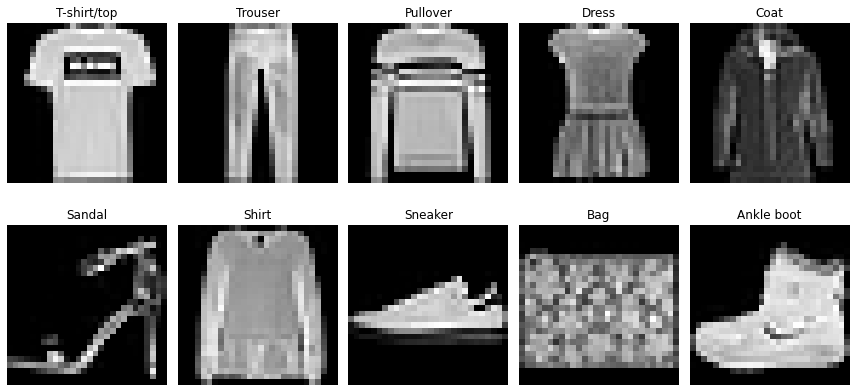

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb (update project and entity with your own values)
wandb.init(project="DL_Assignment_01")

# Load Fashion-MNIST data
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Create a grid plot: 2 rows, 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# For each class, find the first image and plot it
for i, ax in enumerate(axes.flat):
    # Find the index of the first occurrence of class i
    idx = np.where(y_train == i)[0][0]
    # Plot the image in grayscale
    ax.imshow(X_train[idx], cmap="gray")
    ax.set_title(class_names[i])
    ax.axis("off")

plt.tight_layout()

# Log the grid plot to Wandb
wandb.log({"Sample Images": wandb.Image(fig)})

# Display the plot in the notebook
plt.show()

wandb.finish()


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb with your project name
wandb.init(project="DL_Assignment_01")

# Load the Fashion-MNIST data
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# For demonstration, log the grid at multiple steps
num_steps = 3  # You can change this value as needed

for step in range(num_steps):
    # Create a grid plot: 2 rows, 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        # Get the first sample for each class
        idx = np.where(y_train == i)[0][0]
        ax.imshow(X_train[idx], cmap="gray")
        # Set title with the class index and name
        ax.set_title(f"{i}: {class_names[i]}")
        ax.axis("off")
    
    plt.tight_layout()
    
    # Log the grid image with the current step value
    wandb.log({"Sample_Grid": wandb.Image(fig)}, step=step)
    plt.close(fig)

wandb.finish()


wandb: ERROR Control-C detected -- Run data was not synced


In [13]:
import wandb
wandb.login()

True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist
import wandb

# Initialize Wandb with your project name
wandb.init(project="DL_Assignment_01")

# Load the Fashion-MNIST dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Define the class names for Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# For demonstration, log the grid at multiple steps.
# This will create a panel with a step slider in your Wandb dashboard.
num_steps = 3  # For example, log at steps 0, 1, and 2

for step in range(num_steps):
    # Create a grid plot: 2 rows, 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        # Select the first sample for class 'i'
        idx = np.where(y_train == i)[0][0]
        ax.imshow(X_train[idx], cmap="gray")
        # Title includes the class index and class name
        ax.set_title(f"Index: {i}\n{class_names[i]}")
        ax.axis("off")
    
    plt.tight_layout()
    
    # Log the grid image with the current step value
    wandb.log({"Fashion_MNIST_Sample": wandb.Image(fig)}, step=step)
    plt.close(fig)

wandb.finish()


In [14]:
import wandb

# Define the sweep configuration
sweep_config = {
    'method': 'random',  # using random search for efficiency
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

# Create the sweep and print the sweep_id
sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: 1ztchdgb
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/1ztchdgb
Sweep ID: 1ztchdgb


In [7]:
sweep_config = {
    'method': 'bayes',  # Use Bayesian optimization instead of random search
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [0.001, 0.0001]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

sweep_id = wandb.sweep(sweep_config, project="DL_Assignment_01")
print("Sweep ID:", sweep_id)


Create sweep with ID: pu8149xm
Sweep URL: https://wandb.ai/da24m016-indian-institute-of-technology-madras/DL_Assignment_01/sweeps/pu8149xm
Sweep ID: pu8149xm


In [8]:
def sweep_train():
    # Initialize the Wandb run (this pulls hyperparameters from the sweep config)
    wandb.init()
    config = wandb.config
    
    # Load the data using the standard Fashion-MNIST split
    X_train, y_train, X_val, y_val, X_test, y_test = load_data("fashion_mnist")
    input_size = X_train.shape[1]
    output_size = 10  # for 10 classes

    # Create a list of hidden layer sizes: repeat 'hidden_size' for 'num_layers' times
    hidden_sizes = [config.hidden_size] * config.num_layers

    # Initialize the neural network and optimizer
    network = NeuralNetwork(input_size, hidden_sizes, output_size, 
                            activation=config.activation, 
                            weight_init=config.weight_init, 
                            loss_func="cross_entropy")
    
    optimizer = Optimizer(network.params, config.optimizer, config.learning_rate,
                          momentum=0.9,  # you can set default values or include these in the sweep config as well
                          beta=0.9,
                          beta1=0.9,
                          beta2=0.999,
                          epsilon=1e-8,
                          weight_decay=config.weight_decay)
    
    # Train the model using the training function defined earlier
    network = train_model(network, optimizer, X_train, y_train, X_val, y_val, 
                          epochs=config.epochs, batch_size=config.batch_size)
    
    # Evaluate on the validation set
    y_val_pred, _ = network.forward(X_val)
    val_loss = network.compute_loss(y_val_pred, y_val)
    predictions_val = np.argmax(y_val_pred, axis=1)
    true_labels_val = np.argmax(y_val, axis=1)
    val_acc = np.mean(predictions_val == true_labels_val)
    
    # Log final validation metrics
    wandb.log({
        "final_val_loss": val_loss,
        "final_val_accuracy": val_acc
    })
    
    wandb.finish()


In [9]:
# Launch the sweep agent; this will run the training function with different hyperparameter configurations.
wandb.agent(sweep_id, function=sweep_train, count=20)


wandb: Agent Starting Run: p4zcxa4d with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3026, Acc=0.0980, Val Loss=2.3027, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0987, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.0994, Val Loss=2.3028, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0989, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3028, Val Acc=0.0973
Epoch 6/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1011, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1011, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1012, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▂▄▃▄▆███▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▇▅▆▄▄▃▃▁▁
val_accuracy,▁▁▁▁█▁▁▁▁▁
val_loss,▁▅█▆▇▆█▇▇▅
accuracy,0.10076
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30275


wandb: Agent Starting Run: zeyrkk2k with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.3516, Acc=0.0990, Val Loss=2.3082, Val Acc=0.0925
Epoch 2/5: Loss=2.3035, Acc=0.0998, Val Loss=2.3024, Val Acc=0.0973
Epoch 3/5: Loss=2.3030, Acc=0.0973, Val Loss=2.3025, Val Acc=0.1055
Epoch 4/5: Loss=2.3029, Acc=0.0999, Val Loss=2.3026, Val Acc=0.1027
Epoch 5/5: Loss=2.3029, Acc=0.1010, Val Loss=2.3026, Val Acc=0.1050


accuracy,▄▆▁▆█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▁▁▁▁
val_accuracy,▁▄█▆█
val_loss,█▁▁▁▁
accuracy,0.10105
epoch,5
final_val_accuracy,0.105
final_val_loss,2.30261


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qgp8m9jh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.5599, Acc=0.5354, Val Loss=1.1588, Val Acc=0.6647
Epoch 2/5: Loss=1.0323, Acc=0.6800, Val Loss=0.9163, Val Acc=0.7023
Epoch 3/5: Loss=0.8704, Acc=0.7156, Val Loss=0.8049, Val Acc=0.7302
Epoch 4/5: Loss=0.7829, Acc=0.7417, Val Loss=0.7361, Val Acc=0.7570
Epoch 5/5: Loss=0.7245, Acc=0.7602, Val Loss=0.6879, Val Acc=0.7675


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▄▅▇█
val_loss,█▄▃▂▁
accuracy,0.76023
epoch,5
final_val_accuracy,0.7675
final_val_loss,0.68787


wandb: Agent Starting Run: xsm1wgz5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3058, Acc=0.0995, Val Loss=2.3052, Val Acc=0.1050
Epoch 2/10: Loss=2.3050, Acc=0.1003, Val Loss=2.3056, Val Acc=0.1055
Epoch 3/10: Loss=2.3047, Acc=0.1012, Val Loss=2.3054, Val Acc=0.1050
Epoch 4/10: Loss=2.3044, Acc=0.1002, Val Loss=2.3053, Val Acc=0.1027
Epoch 5/10: Loss=2.3044, Acc=0.1029, Val Loss=2.3024, Val Acc=0.1050
Epoch 6/10: Loss=2.3041, Acc=0.0999, Val Loss=2.3033, Val Acc=0.0985
Epoch 7/10: Loss=2.3035, Acc=0.1051, Val Loss=2.3047, Val Acc=0.1027
Epoch 8/10: Loss=2.3034, Acc=0.1025, Val Loss=2.3031, Val Acc=0.0985
Epoch 9/10: Loss=2.3027, Acc=0.1042, Val Loss=2.3017, Val Acc=0.0942
Epoch 10/10: Loss=2.3020, Acc=0.1054, Val Loss=2.3018, Val Acc=0.1032


accuracy,▁▂▃▂▅▁█▅▇█
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▆▅▅▅▄▄▂▁
val_accuracy,███▆█▄▆▄▁▇
val_loss,▇██▇▂▄▆▄▁▁
accuracy,0.10541
epoch,10
final_val_accuracy,0.10317
final_val_loss,2.3018


wandb: Agent Starting Run: bb3ijrb9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.3026, Acc=0.0979, Val Loss=2.3026, Val Acc=0.0925
Epoch 2/10: Loss=2.3026, Acc=0.0983, Val Loss=2.3027, Val Acc=0.0925
Epoch 3/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3027, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1003, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1001, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1002, Val Loss=2.3028, Val Acc=0.0925


accuracy,▁▂█▅▆▇█▇█▇
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▁▂▂▂▁▁▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▅▆▆▇▇███
accuracy,0.10024
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30278


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e9a4zmwe with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.0056, Acc=0.3787, Val Loss=1.6844, Val Acc=0.5960
Epoch 2/5: Loss=1.4128, Acc=0.6239, Val Loss=1.1644, Val Acc=0.6587
Epoch 3/5: Loss=1.0375, Acc=0.6661, Val Loss=0.9165, Val Acc=0.6923
Epoch 4/5: Loss=0.8709, Acc=0.6978, Val Loss=0.8065, Val Acc=0.7210
Epoch 5/5: Loss=0.7878, Acc=0.7211, Val Loss=0.7437, Val Acc=0.7397


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▁▁
accuracy,0.7211
epoch,5
final_val_accuracy,0.73967
final_val_loss,0.74372


wandb: Agent Starting Run: p3e0uwtz with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.3026, Acc=0.1050, Val Loss=2.3026, Val Acc=0.0948
Epoch 2/5: Loss=2.3026, Acc=0.1092, Val Loss=2.3026, Val Acc=0.0987
Epoch 3/5: Loss=2.3026, Acc=0.1314, Val Loss=2.3026, Val Acc=0.1095
Epoch 4/5: Loss=2.3026, Acc=0.1056, Val Loss=2.3026, Val Acc=0.1252
Epoch 5/5: Loss=2.3026, Acc=0.1183, Val Loss=2.3026, Val Acc=0.1417


accuracy,▁▂█▁▅
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▅▃▁
val_accuracy,▁▂▃▆█
val_loss,█▅▁▁▁
accuracy,0.11827
epoch,5
final_val_accuracy,0.14167
final_val_loss,2.3026


wandb: Agent Starting Run: l5brcx7g with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.0016, Acc=0.3362, Val Loss=1.5218, Val Acc=0.5260
Epoch 2/10: Loss=1.1430, Acc=0.6355, Val Loss=0.8952, Val Acc=0.6937
Epoch 3/10: Loss=0.8205, Acc=0.7090, Val Loss=0.7415, Val Acc=0.7385
Epoch 4/10: Loss=0.7133, Acc=0.7474, Val Loss=0.6686, Val Acc=0.7563
Epoch 5/10: Loss=0.6513, Acc=0.7732, Val Loss=0.6235, Val Acc=0.7770
Epoch 6/10: Loss=0.6087, Acc=0.7879, Val Loss=0.5860, Val Acc=0.7965
Epoch 7/10: Loss=0.5775, Acc=0.8003, Val Loss=0.5587, Val Acc=0.8037
Epoch 8/10: Loss=0.5525, Acc=0.8085, Val Loss=0.5371, Val Acc=0.8125
Epoch 9/10: Loss=0.5320, Acc=0.8146, Val Loss=0.5243, Val Acc=0.8180
Epoch 10/10: Loss=0.5170, Acc=0.8202, Val Loss=0.5069, Val Acc=0.8225


accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇████
val_loss,█▄▃▂▂▂▁▁▁▁
accuracy,0.82017
epoch,10
final_val_accuracy,0.8225
final_val_loss,0.50694


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9su5rfok with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.2756, Acc=0.2617, Val Loss=2.2982, Val Acc=0.1488
Epoch 2/10: Loss=2.3019, Acc=0.1125, Val Loss=2.3028, Val Acc=0.0942
Epoch 3/10: Loss=2.3026, Acc=0.0996, Val Loss=2.3027, Val Acc=0.1003
Epoch 4/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.1003
Epoch 5/10: Loss=2.3026, Acc=0.0999, Val Loss=2.3027, Val Acc=0.1003
Epoch 6/10: Loss=2.3026, Acc=0.0993, Val Loss=2.3027, Val Acc=0.1003
Epoch 7/10: Loss=2.3026, Acc=0.0995, Val Loss=2.3027, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1000, Val Loss=2.3027, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1005, Val Loss=2.3027, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▂▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁█████████
val_accuracy,█▁▂▂▂▂▁▁▁▁
val_loss,▁█████████
accuracy,0.10085
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30275


wandb: Agent Starting Run: l28oiyjw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.6941, Acc=0.4941, Val Loss=1.1267, Val Acc=0.6755
Epoch 2/5: Loss=0.9371, Acc=0.6951, Val Loss=0.8017, Val Acc=0.7328
Epoch 3/5: Loss=0.7554, Acc=0.7432, Val Loss=0.6974, Val Acc=0.7647
Epoch 4/5: Loss=0.6734, Acc=0.7704, Val Loss=0.6358, Val Acc=0.7823
Epoch 5/5: Loss=0.6202, Acc=0.7891, Val Loss=0.5927, Val Acc=0.7930


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▂▂▁
accuracy,0.78912
epoch,5
final_val_accuracy,0.793
final_val_loss,0.59273


wandb: Agent Starting Run: 97bzlwqr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.1960, Acc=0.1753, Val Loss=2.0840, Val Acc=0.2487
Epoch 2/5: Loss=1.9957, Acc=0.3135, Val Loss=1.9116, Val Acc=0.3978
Epoch 3/5: Loss=1.8412, Acc=0.4353, Val Loss=1.7707, Val Acc=0.4785
Epoch 4/5: Loss=1.7133, Acc=0.5003, Val Loss=1.6538, Val Acc=0.5258
Epoch 5/5: Loss=1.6073, Acc=0.5381, Val Loss=1.5565, Val Acc=0.5537


accuracy,▁▄▆▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▆▄▂▁
val_accuracy,▁▄▆▇█
val_loss,█▆▄▂▁
accuracy,0.53815
epoch,5
final_val_accuracy,0.55367
final_val_loss,1.55648


wandb: Agent Starting Run: qax4nvez with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.1527, Acc=0.3143, Val Loss=1.9427, Val Acc=0.4903
Epoch 2/5: Loss=1.6328, Acc=0.5507, Val Loss=1.3091, Val Acc=0.6282
Epoch 3/5: Loss=1.1279, Acc=0.6432, Val Loss=0.9700, Val Acc=0.6677
Epoch 4/5: Loss=0.9036, Acc=0.6846, Val Loss=0.8248, Val Acc=0.7008
Epoch 5/5: Loss=0.7984, Acc=0.7175, Val Loss=0.7521, Val Acc=0.7257


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
accuracy,0.71749
epoch,5
final_val_accuracy,0.72567
final_val_loss,0.75213


wandb: Agent Starting Run: n94e72ut with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=2.2242, Acc=0.4305, Val Loss=2.2632, Val Acc=0.5625
Epoch 2/10: Loss=2.2882, Acc=0.3440, Val Loss=2.3001, Val Acc=0.1313
Epoch 3/10: Loss=2.3018, Acc=0.1014, Val Loss=2.3027, Val Acc=0.0925
Epoch 4/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 5/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 6/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 7/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 8/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925
Epoch 9/10: Loss=2.3026, Acc=0.1008, Val Loss=2.3028, Val Acc=0.0925
Epoch 10/10: Loss=2.3026, Acc=0.1009, Val Loss=2.3028, Val Acc=0.0925


accuracy,█▆▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,▁▇████████
val_accuracy,█▂▁▁▁▁▁▁▁▁
val_loss,▁█████████
accuracy,0.10086
epoch,10
final_val_accuracy,0.0925
final_val_loss,2.30277


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xatjpda3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=2.2864, Acc=0.1650, Val Loss=2.2769, Val Acc=0.1777
Epoch 2/5: Loss=2.2692, Acc=0.1978, Val Loss=2.2640, Val Acc=0.2128
Epoch 3/5: Loss=2.2604, Acc=0.2387, Val Loss=2.2578, Val Acc=0.2553
Epoch 4/5: Loss=2.2566, Acc=0.2761, Val Loss=2.2556, Val Acc=0.2913
Epoch 5/5: Loss=2.2559, Acc=0.3048, Val Loss=2.2559, Val Acc=0.3160


accuracy,▁▃▅▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▃▅▇█
val_loss,█▄▂▁▁
accuracy,0.30483
epoch,5
final_val_accuracy,0.316
final_val_loss,2.25587


wandb: Agent Starting Run: uoci70xl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=0.6924, Acc=0.7665, Val Loss=0.4951, Val Acc=0.8218
Epoch 2/10: Loss=0.4510, Acc=0.8400, Val Loss=0.4310, Val Acc=0.8462
Epoch 3/10: Loss=0.4049, Acc=0.8550, Val Loss=0.3902, Val Acc=0.8567
Epoch 4/10: Loss=0.3748, Acc=0.8664, Val Loss=0.3753, Val Acc=0.8638
Epoch 5/10: Loss=0.3551, Acc=0.8720, Val Loss=0.3781, Val Acc=0.8660
Epoch 6/10: Loss=0.3402, Acc=0.8772, Val Loss=0.3493, Val Acc=0.8735
Epoch 7/10: Loss=0.3265, Acc=0.8818, Val Loss=0.3453, Val Acc=0.8782
Epoch 8/10: Loss=0.3154, Acc=0.8849, Val Loss=0.3597, Val Acc=0.8673
Epoch 9/10: Loss=0.3059, Acc=0.8889, Val Loss=0.3597, Val Acc=0.8682
Epoch 10/10: Loss=0.2983, Acc=0.8921, Val Loss=0.3494, Val Acc=0.8755


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▆▇█▇▇█
val_loss,█▅▃▂▃▁▁▂▂▁
accuracy,0.89213
epoch,10
final_val_accuracy,0.8755
final_val_loss,0.34938


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ytx8soot with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=1.6546, Acc=0.5269, Val Loss=1.2148, Val Acc=0.6670
Epoch 2/5: Loss=1.0538, Acc=0.6984, Val Loss=0.9246, Val Acc=0.7210
Epoch 3/5: Loss=0.8698, Acc=0.7321, Val Loss=0.8033, Val Acc=0.7448
Epoch 4/5: Loss=0.7774, Acc=0.7531, Val Loss=0.7334, Val Acc=0.7660
Epoch 5/5: Loss=0.7178, Acc=0.7676, Val Loss=0.6853, Val Acc=0.7763


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▂▁▁
val_accuracy,▁▄▆▇█
val_loss,█▄▃▂▁
accuracy,0.76765
epoch,5
final_val_accuracy,0.77633
final_val_loss,0.68527


wandb: Agent Starting Run: mxlfgkz9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/10: Loss=0.6404, Acc=0.7802, Val Loss=0.4511, Val Acc=0.8355
Epoch 2/10: Loss=0.4262, Acc=0.8505, Val Loss=0.4129, Val Acc=0.8532
Epoch 3/10: Loss=0.3861, Acc=0.8633, Val Loss=0.3741, Val Acc=0.8627
Epoch 4/10: Loss=0.3599, Acc=0.8721, Val Loss=0.3696, Val Acc=0.8680
Epoch 5/10: Loss=0.3406, Acc=0.8778, Val Loss=0.3558, Val Acc=0.8700
Epoch 6/10: Loss=0.3260, Acc=0.8819, Val Loss=0.3563, Val Acc=0.8727
Epoch 7/10: Loss=0.3131, Acc=0.8867, Val Loss=0.3394, Val Acc=0.8800
Epoch 8/10: Loss=0.3034, Acc=0.8882, Val Loss=0.3330, Val Acc=0.8808
Epoch 9/10: Loss=0.2925, Acc=0.8938, Val Loss=0.3293, Val Acc=0.8810
Epoch 10/10: Loss=0.2831, Acc=0.8956, Val Loss=0.3448, Val Acc=0.8737


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
final_val_accuracy,▁
final_val_loss,▁
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▆▇███▇
val_loss,█▆▄▃▃▃▂▁▁▂
accuracy,0.89558
epoch,10
final_val_accuracy,0.87367
final_val_loss,0.34478


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3xe5y2p2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6696, Acc=0.7763, Val Loss=0.4458, Val Acc=0.8385
Epoch 2/5: Loss=0.4286, Acc=0.8481, Val Loss=0.4058, Val Acc=0.8497
Epoch 3/5: Loss=0.3913, Acc=0.8604, Val Loss=0.3955, Val Acc=0.8547
Epoch 4/5: Loss=0.3701, Acc=0.8669, Val Loss=0.3829, Val Acc=0.8588
Epoch 5/5: Loss=0.3547, Acc=0.8723, Val Loss=0.3819, Val Acc=0.8598


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▂▁▁
accuracy,0.87229
epoch,5
final_val_accuracy,0.85983
final_val_loss,0.38195


wandb: Agent Starting Run: zwhqyhqp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6522, Acc=0.7708, Val Loss=0.4775, Val Acc=0.8372
Epoch 2/5: Loss=0.4268, Acc=0.8488, Val Loss=0.4084, Val Acc=0.8565
Epoch 3/5: Loss=0.3904, Acc=0.8607, Val Loss=0.3856, Val Acc=0.8602
Epoch 4/5: Loss=0.3663, Acc=0.8679, Val Loss=0.3664, Val Acc=0.8700
Epoch 5/5: Loss=0.3463, Acc=0.8756, Val Loss=0.3546, Val Acc=0.8730


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▅▇█
val_loss,█▄▃▂▁
accuracy,0.87563
epoch,5
final_val_accuracy,0.873
final_val_loss,0.35461


wandb: Agent Starting Run: 7wt3iqpy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 1/5: Loss=0.6709, Acc=0.7713, Val Loss=0.4742, Val Acc=0.8353
Epoch 2/5: Loss=0.4394, Acc=0.8451, Val Loss=0.4106, Val Acc=0.8535
Epoch 3/5: Loss=0.3942, Acc=0.8608, Val Loss=0.3835, Val Acc=0.8625
Epoch 4/5: Loss=0.3684, Acc=0.8689, Val Loss=0.3649, Val Acc=0.8658
Epoch 5/5: Loss=0.3477, Acc=0.8752, Val Loss=0.3570, Val Acc=0.8698


accuracy,▁▆▇██
epoch,▁▃▅▆█
final_val_accuracy,▁
final_val_loss,▁
loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▄▃▁▁
accuracy,0.87519
epoch,5
final_val_accuracy,0.86983
final_val_loss,0.35702
